In [27]:
import requests
import json
import time
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
Notre projet portera sur le jeu League of Legends. C’est un jeu d’équipe en ligne
en 5 contre 5. Vous pouvez si vous le souhaitez regarder un tutoriel de 3 minutes
si vous avez envie de vous familiariser avec le jeu pour avoir une meilleure
compréhension globale sur le thème de notre projet.
https://www.youtube.com/watch?v=0MEOdboHk8o&ab_channel=GentleMates

# 1 - Collection de notre jeu de données

Pour collecter nos données, nous sommes directement allés les chercher à la source en se branchant à l’api du jeu. On y récupère les noms des meilleurs joueurs du serveur européen. On fait ce choix car ces parties de haut niveaux sont moins hasardeuses et il en découlera des données plus fiables.

Il faut aussi prendre en compte les restrictions de l’api concernant le nombre de requêtes, on a pour cela créé plusieurs comptes particuliers afin de faire des requêtes en parrallèles sur plus de comptes.

Nous avons séparé tout le processus de requêtes api dans le fichier api_process. Ce fichier contiendra le code en rapport direct avec les jalons et le rendu final du projet.

# Update depuis le jalon 2 : 
Même si nous en avions l'intuition, prédire l'issue d'une partie en prenant ses caractéristiques à l'instant final de la partie était trop simple (environ 1 d'accuracy dès la régression logistique en cross validation).

On revoit donc tout le dataset pour prendre des informations à un instant t (exemple ici : 15 minutes) de la partie pour en prédire son issue. On aura donc des résultats plus pertinents avec une vraie utilité avec un peu plus de challenge.

Le processus de récolte de données, de filtrage des parties de moins de 15 minutes etc.. est disponible dans le notebook api_processs. 

On a gardé une trace de nos anciennes accuracys dans le fichier accuracy_with_single_feature.txt.



In [30]:
data = pd.read_csv('data_15min_final.csv')
target = data['winningTeam']
data.drop(columns='winningTeam', inplace=True)

In [31]:
data

Team1.championStats.abilityHaste  Team1.championStats.abilityPower  \
0                                    0                               177   
1                                    0                               185   
2                                    0                               186   
3                                    0                               195   
4                                    0                               230   
...                                ...                               ...   
9813                                 0                               334   
9814                                 0                               225   
9815                                 0                               456   
9816                                 0                               188   
9817                                 0                               288   

      Team1.championStats.armor  Team1.championStats.armorPen  \
0                           352                             0   
1                           446                             0   
2                           466                             0   
3                           307                             0   
4                           348                             0   
...                         ...                           ...   
9813                        307                             0   
9814                        362                             0   
9815                        380                             0   
9816                        393                             0   
9817                        419                             0   

      Team1.championStats.armorPenPercent  Team1.championStats.attackDamage  \
0                                       0                               628   
1                                       0                               551   
2                                       0                               603   
3                                       0                               746   
4                                      30                               759   
...                                   ...                               ...   
9813                                    0                               867   
9814                                    0                               664   
9815                                    0                               817   
9816                                    0                               651   
9817                                    0                               520   

      Team1.championStats.attackSpeed  \
0                                 817   
1                                 618   
2                                 826   
3                                 945   
4                                 635   
...                               ...   
9813                              512   
9814                              692   
9815                              818   
9816                              798   
9817                              713   

      Team1.championStats.bonusArmorPenPercent  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   
...                                        ...   
9813                                         0   
9814                                         0   
9815                                         0   
9816                                         0   
9817                                         0   

      Team1.championStats.bonusMagicPenPercent  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                  

In [50]:
data.describe()

Team1.championStats.abilityHaste  Team1.championStats.abilityPower  \
count                            9818.0                       9818.000000   
mean                                0.0                        235.988389   
std                                 0.0                        102.364094   
min                                 0.0                          0.000000   
25%                                 0.0                        161.000000   
50%                                 0.0                        222.000000   
75%                                 0.0                        299.000000   
max                                 0.0                        776.000000   

       Team1.championStats.armor  Team1.championStats.armorPen  \
count                9818.000000                        9818.0   
mean                  367.605419                           0.0   
std                    51.235050                           0.0   
min                   263.000000                           0.0   
25%                   331.000000                           0.0   
50%                   360.000000                           0.0   
75%                   395.000000                           0.0   
max                   726.000000                           0.0   

       Team1.championStats.armorPenPercent  Team1.championStats.attackDamage  \
count                          9818.000000                       9818.000000   
mean                              1.377776                        633.077205   
std                               5.749763                         80.809331   
min                               0.000000                        410.000000   
25%                               0.000000                        575.000000   
50%                               0.000000                        628.000000   
75%                               0.000000                        683.000000   
max                              48.000000                       1092.000000   

       Team1.championStats.attackSpeed  \
count                      9818.000000   
mean                        750.664799   
std                          85.775827   
min                         512.000000   
25%                         690.000000   
50%                         740.000000   
75%                         799.000000   
max                        1283.000000   

       Team1.championStats.bonusArmorPenPercent  \
count                                    9818.0   
mean                                        0.0   
std                                         0.0   
min                                         0.0   
25%                                         0.0   
50%                                         0.0   
75%                                         0.0   
max                                         0.0   

       Team1.championStats.bonusMagicPenPercent  \
count                                    9818.0   
mean                                        0.0   
std                                         0.0   
min                                         0.0   
25%                                         0.0   
50%                                         0.0   
75%                                         0.0   
max                                         0.0   

       Team1.championStats.ccReduction  ...  Team2.goldPerSecond  \
count                      9818.000000  ...          9818.000000   
mean                         23.865349  ...            50.113058   
std                          24.537527  ...             2.596306   
min                         -30.000000  ...             0.000000   
25%                           0.000000  ...            50.000000   
50%                          19.000000  ...            50.000000   
75%                          37.000000  ...            50.000000   
max                         157.000000  ...           100.000000   

       Team2.jungleMinionsKilled  Team2.level  Team2.minionsKilled  \
count          

In [32]:
target

0       1
1       1
2       1
3       0
4       1
       ..
9813    1
9814    1
9815    0
9816    1
9817    0
Name: winningTeam, Length: 9818, dtype: int64

In [9]:
#count nan
data.isnull().sum().any()


False

In [10]:
target.isnull().sum().any()

False

# Visualisation du dataset

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

In [6]:
data = pd.read_csv('data_15min_final.csv')
target = data['winningTeam']

In [7]:
target

0       1
1       1
2       1
3       0
4       1
       ..
9813    1
9814    1
9815    0
9816    1
9817    0
Name: winningTeam, Length: 9818, dtype: int64

# Histogrammes 

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


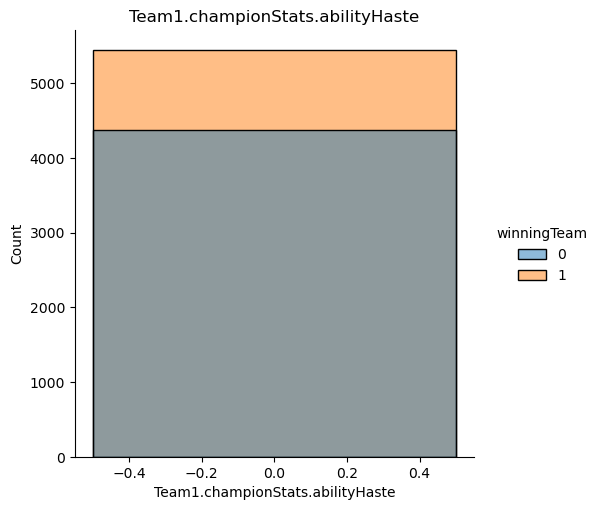

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


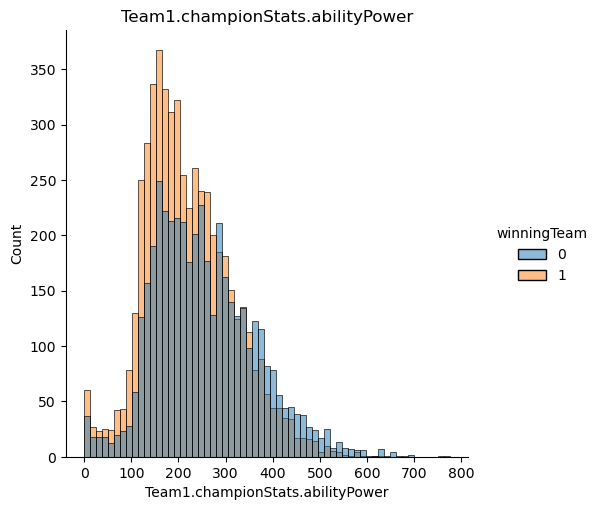

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


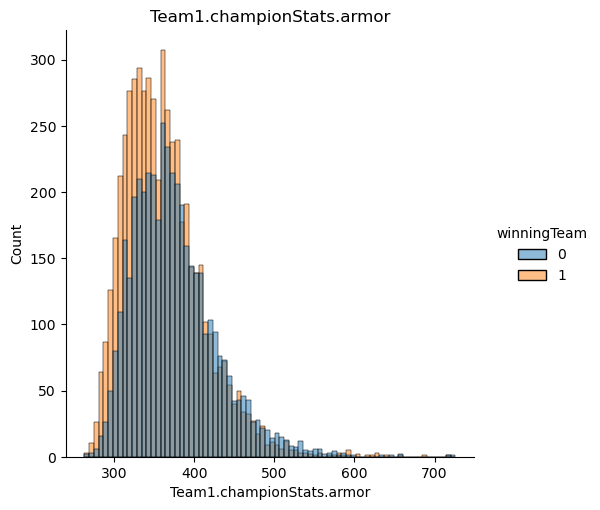

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


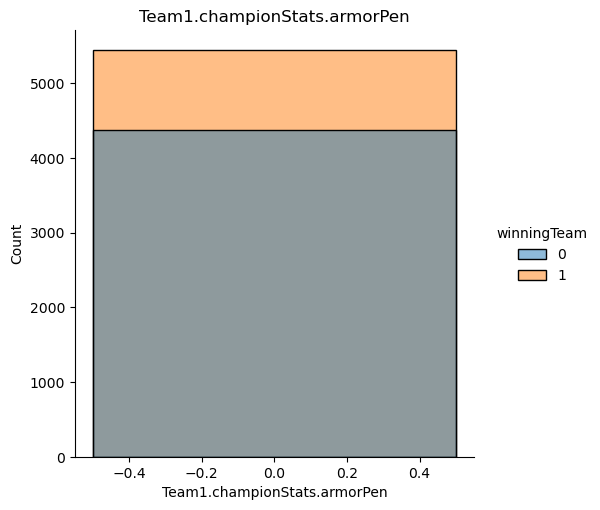

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


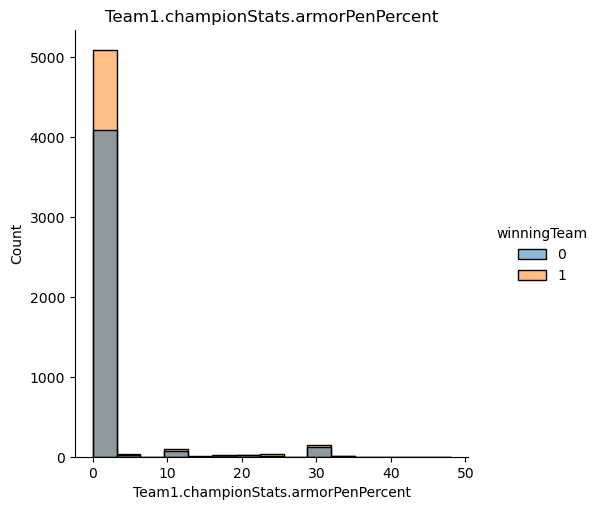

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


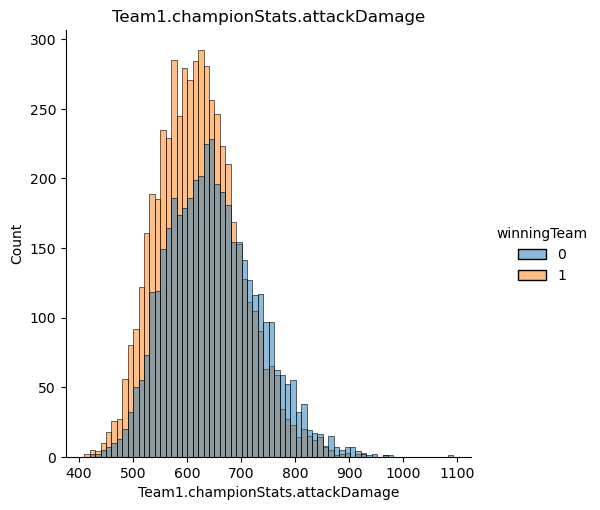

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


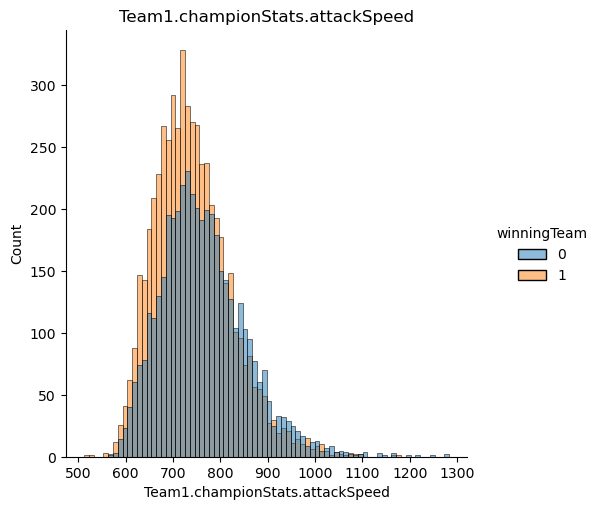

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


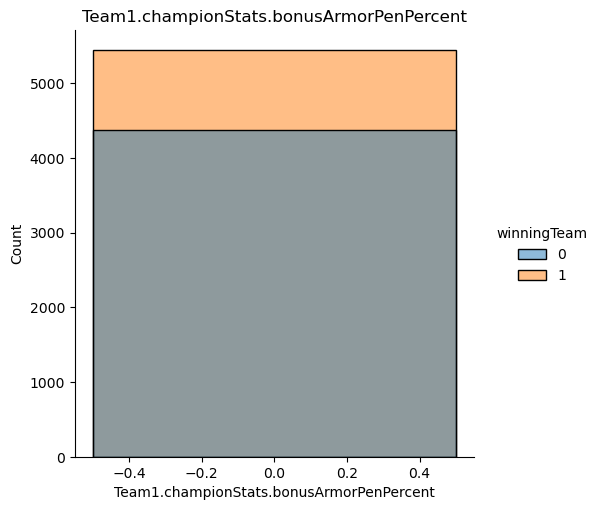

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


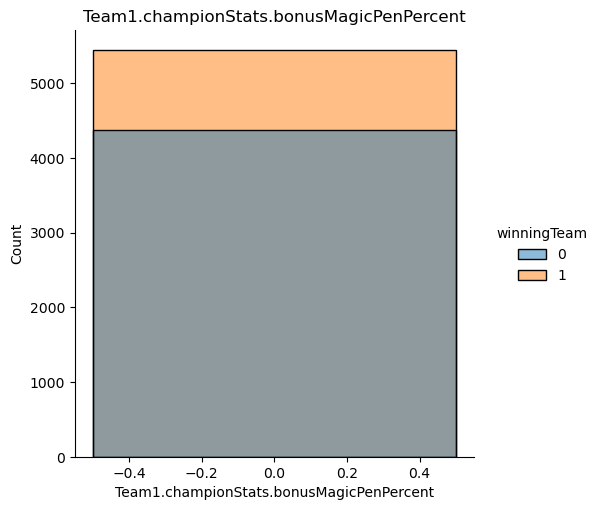

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


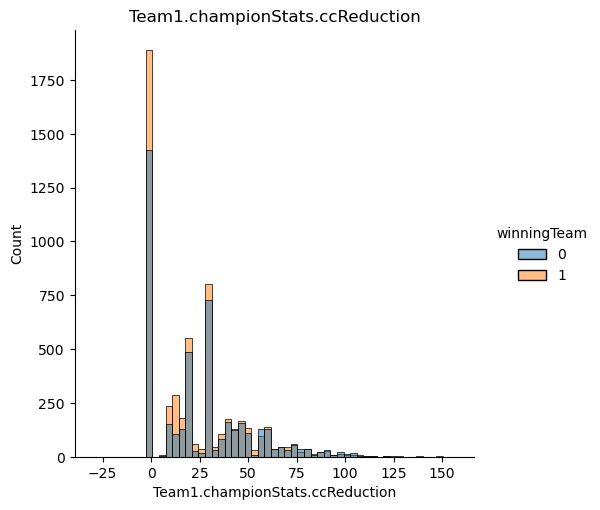

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


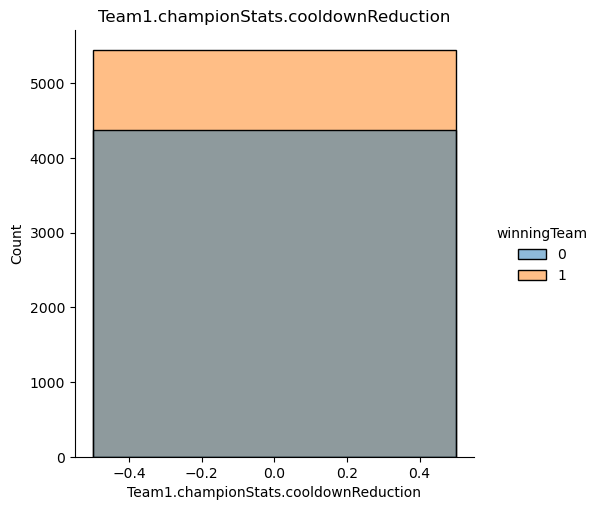

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


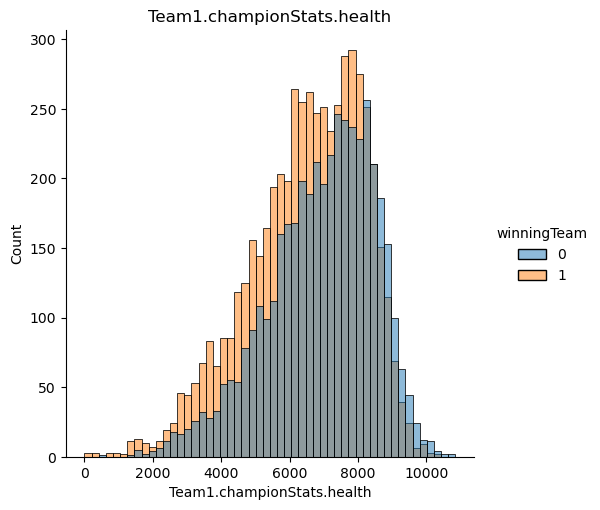

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


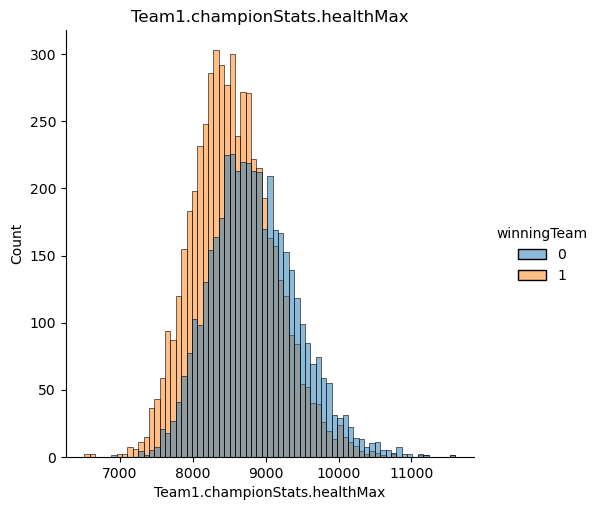

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


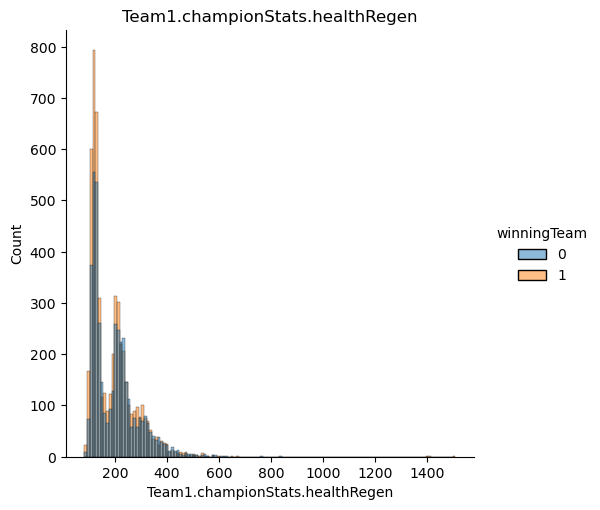

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


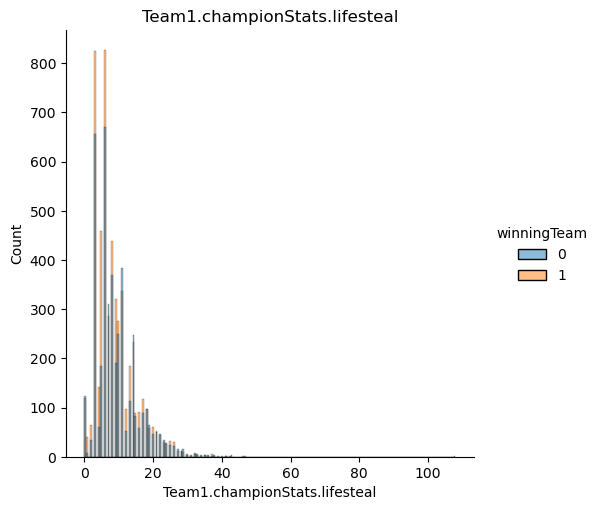

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


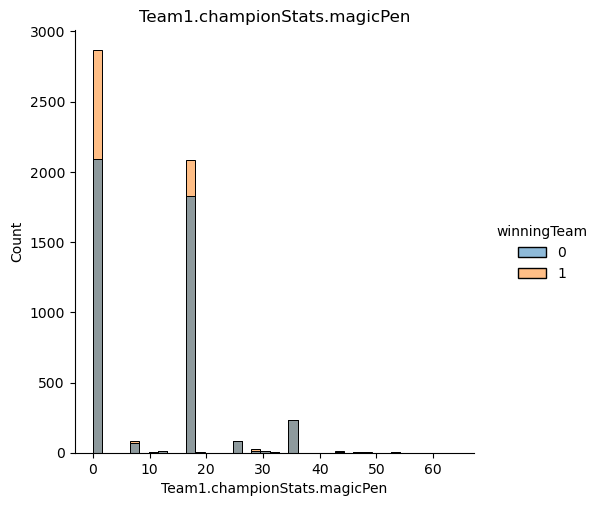

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


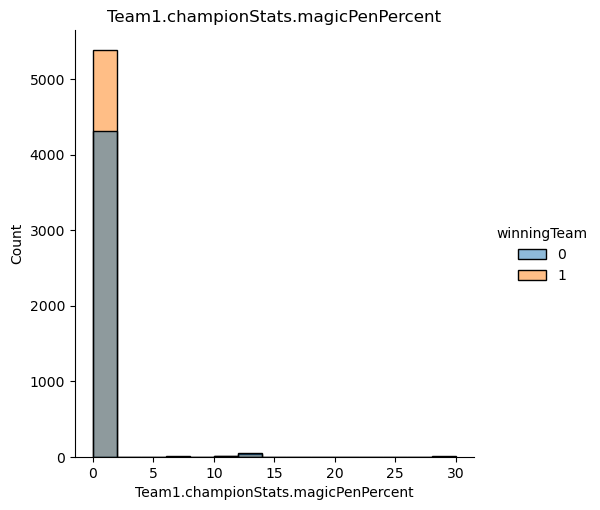

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


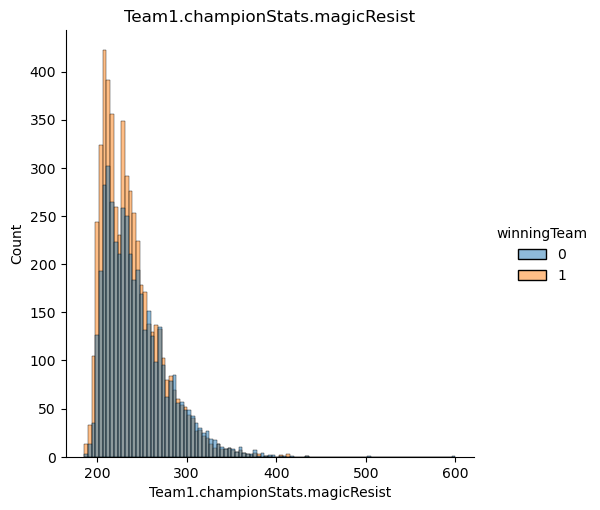

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


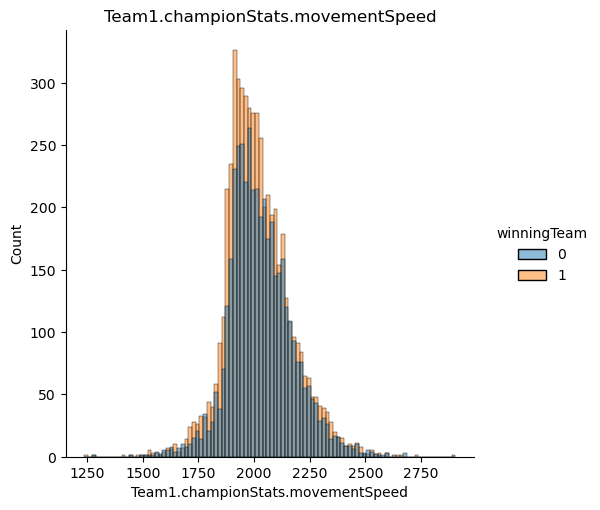

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


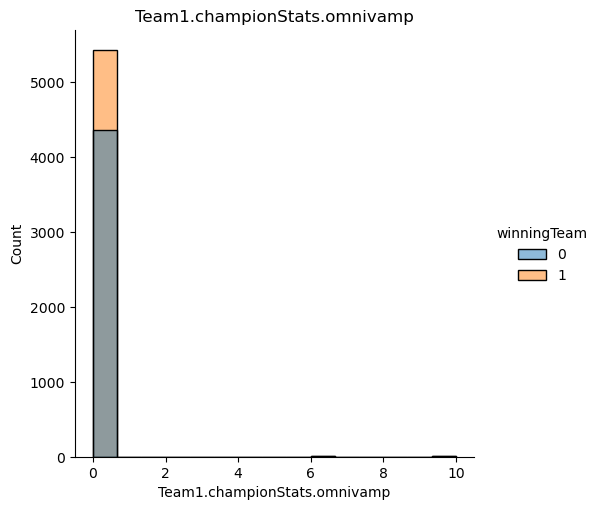

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


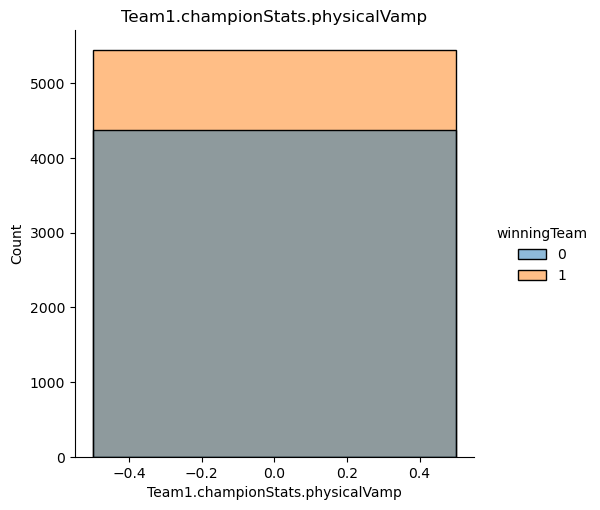

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


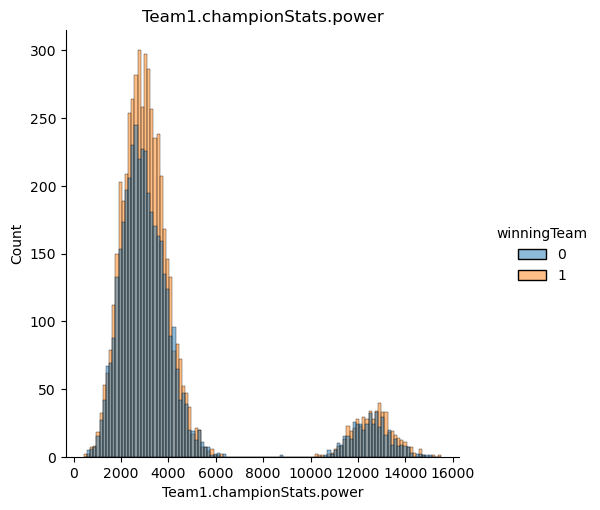

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


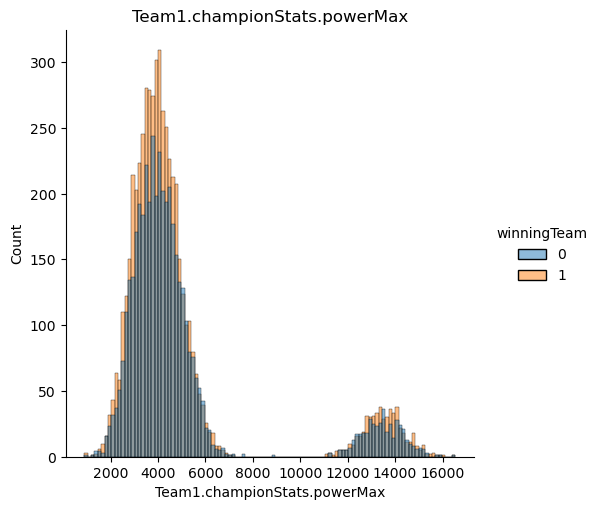

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


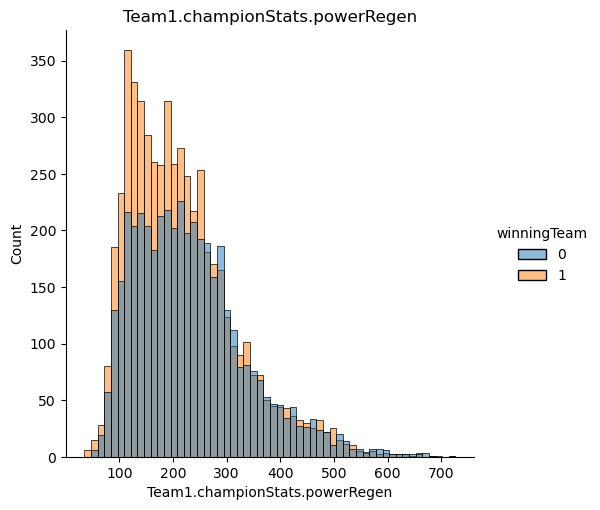

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


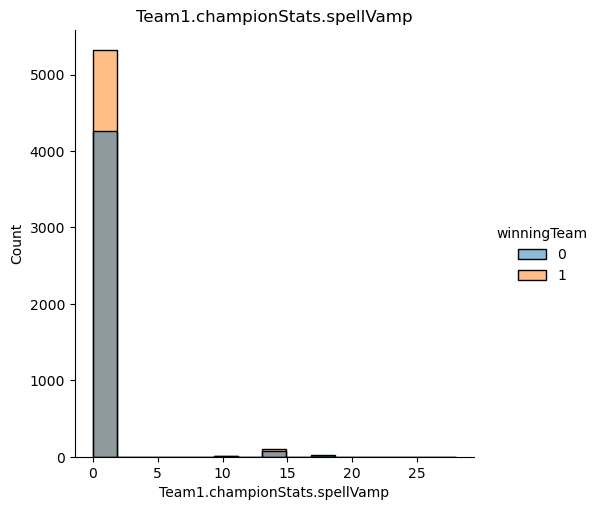

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


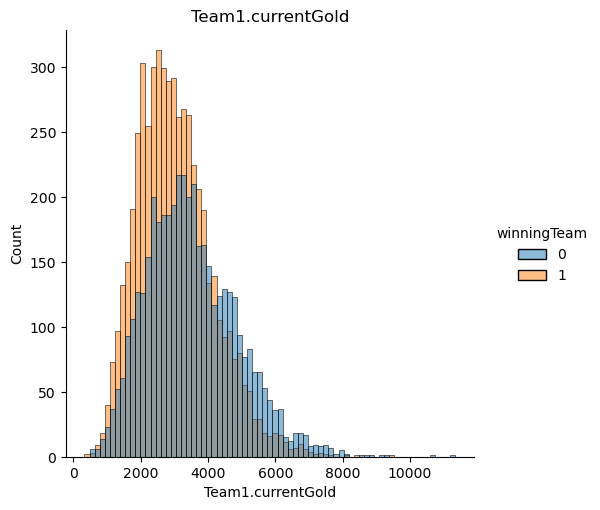

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


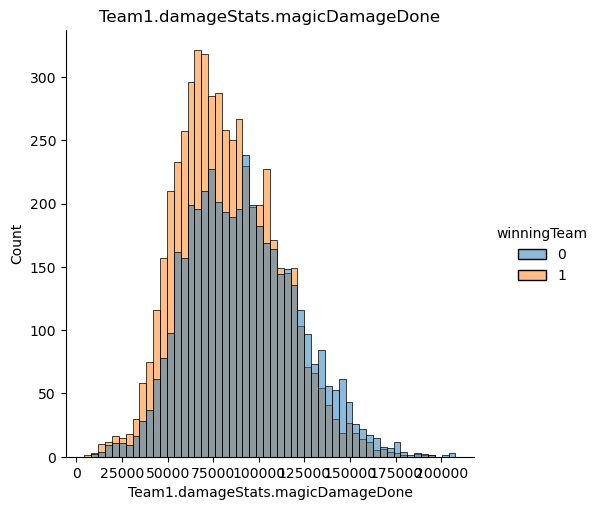

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


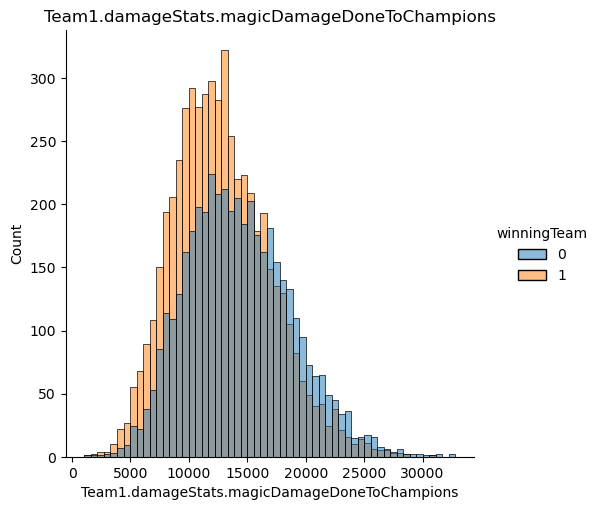

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


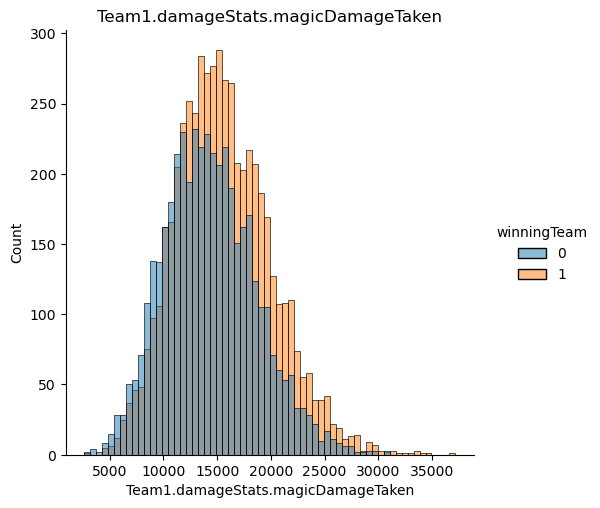

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


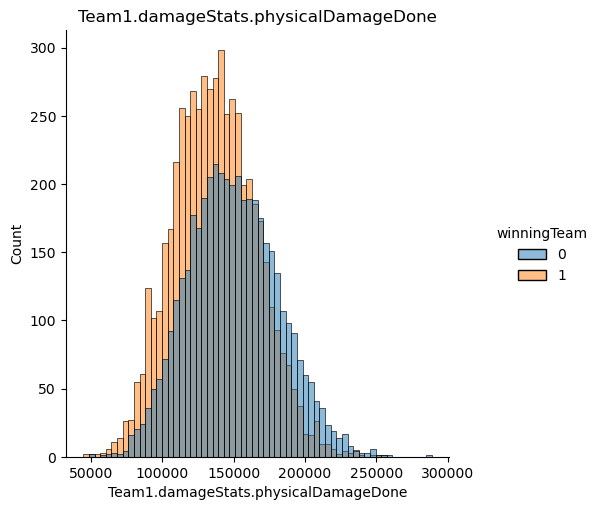

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


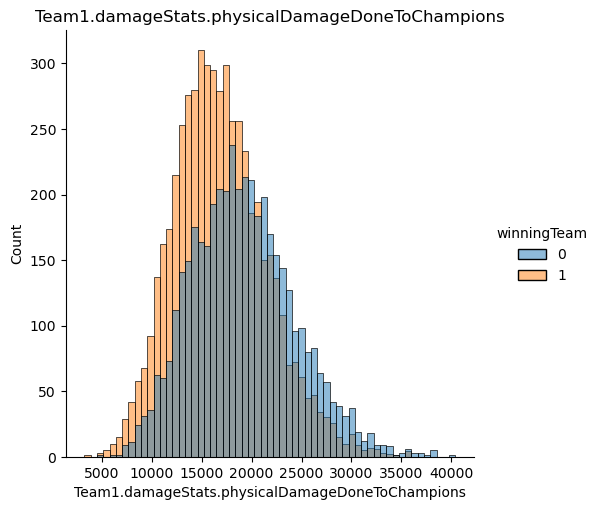

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


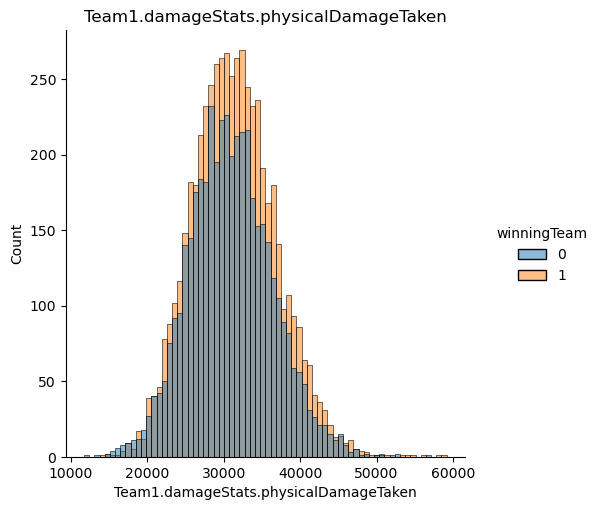

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


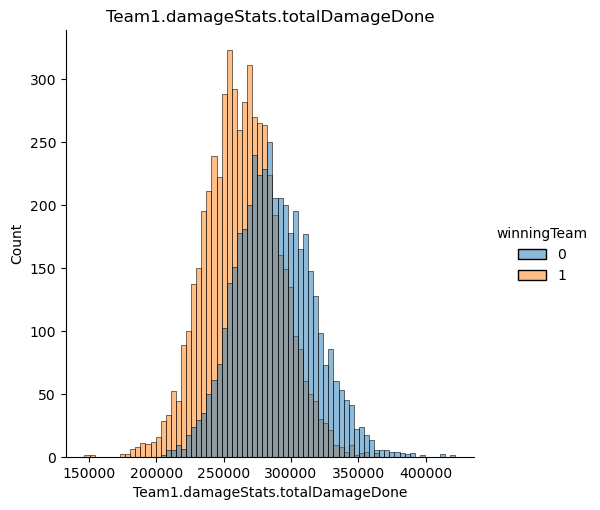

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


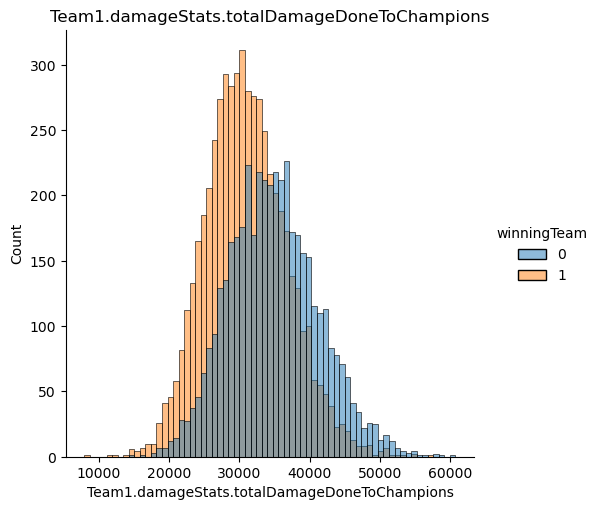

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


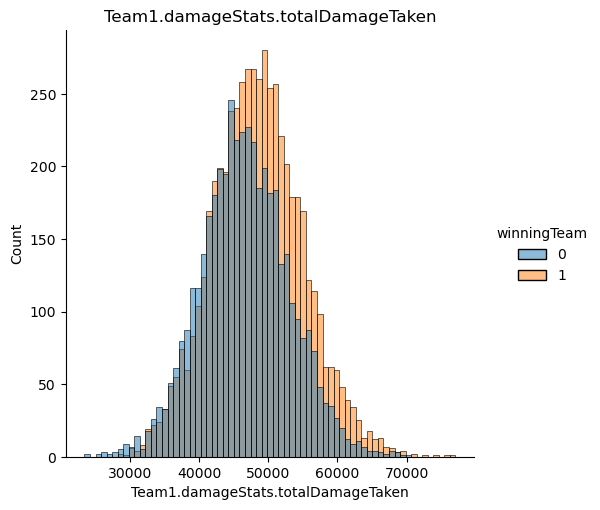

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


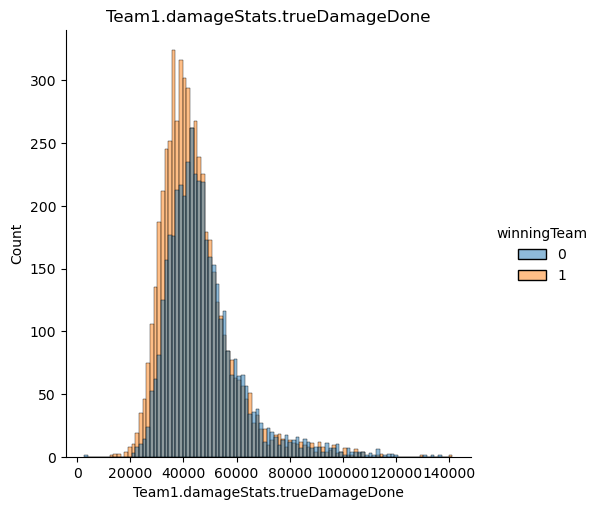

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


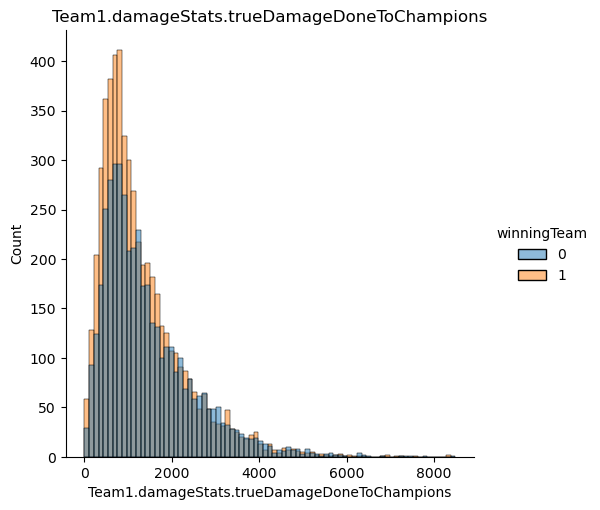

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


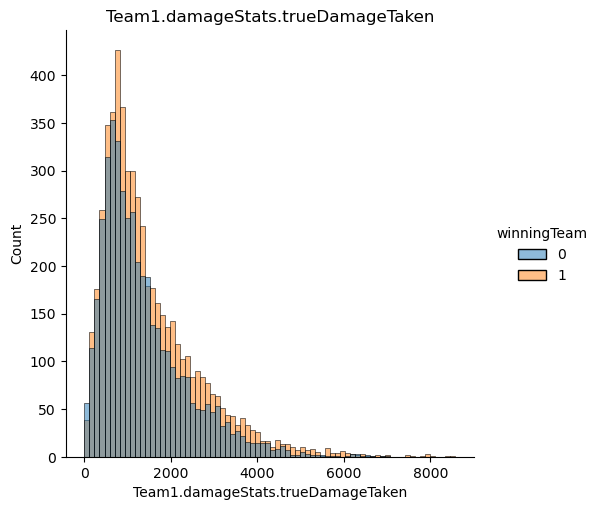

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


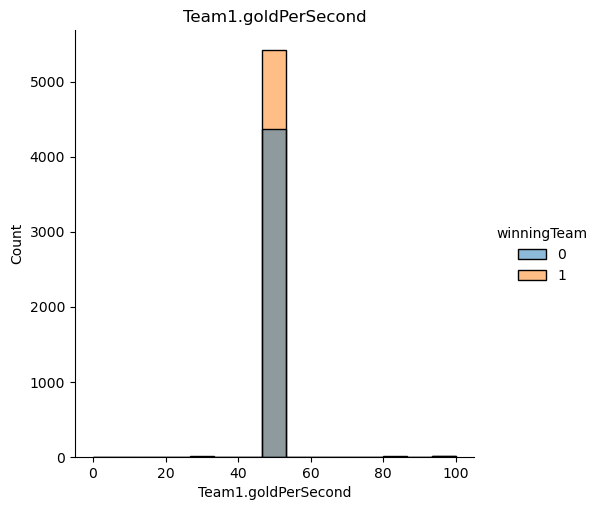

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


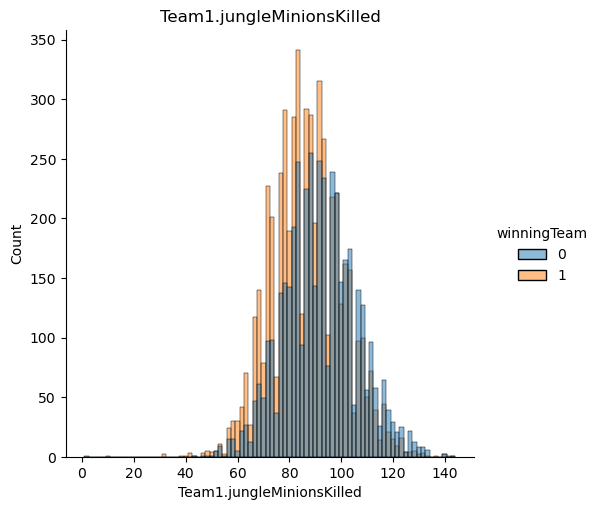

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


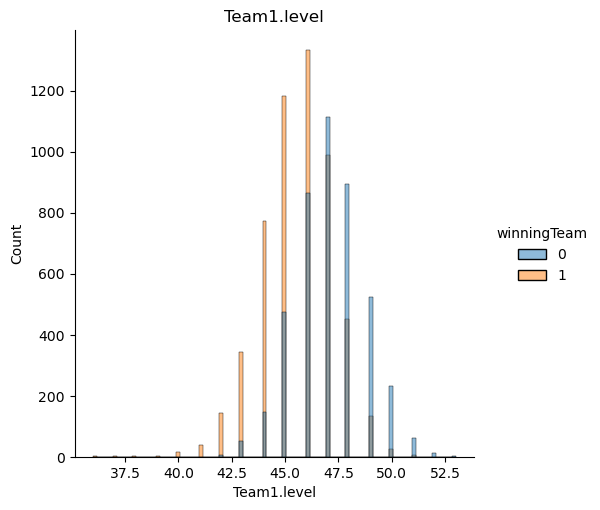

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


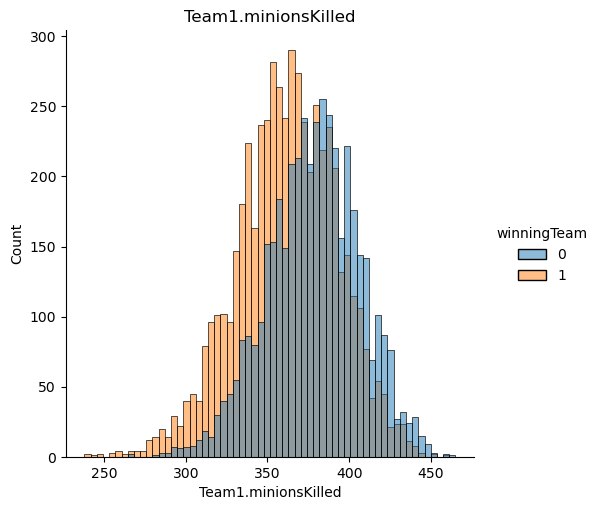

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


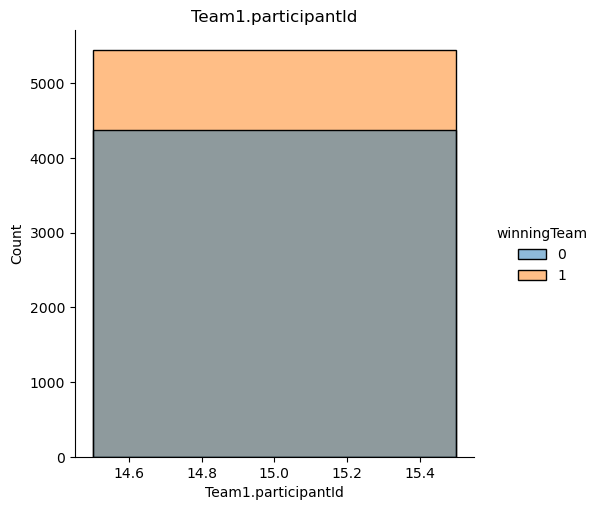

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


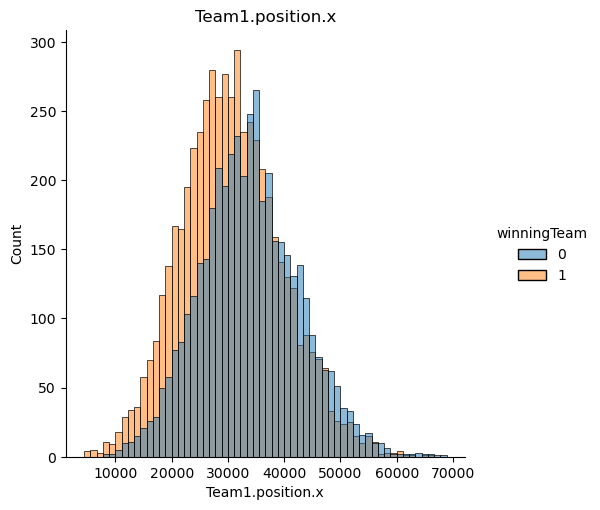

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


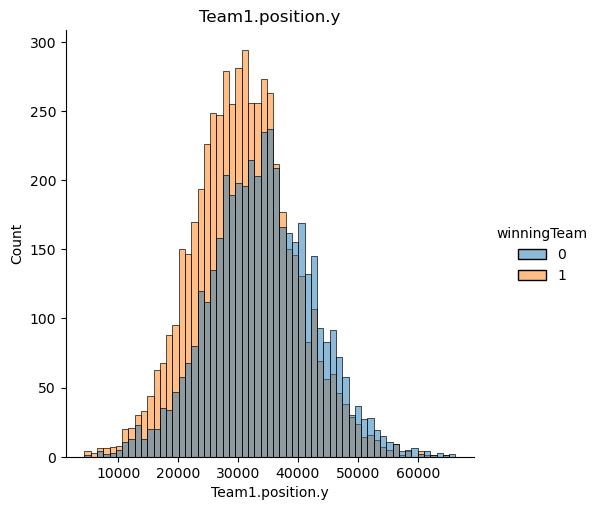

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


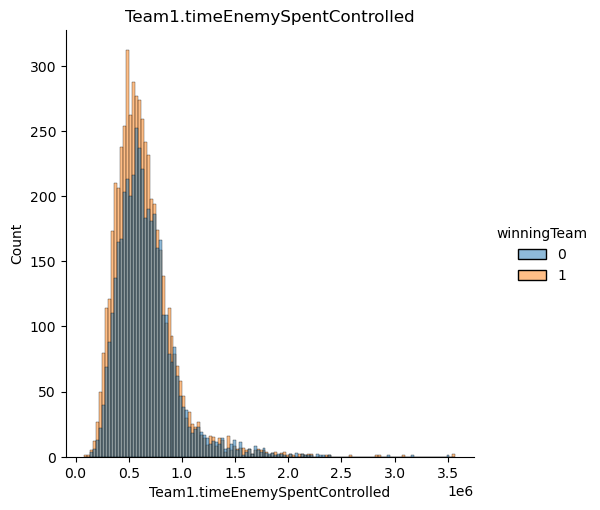

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


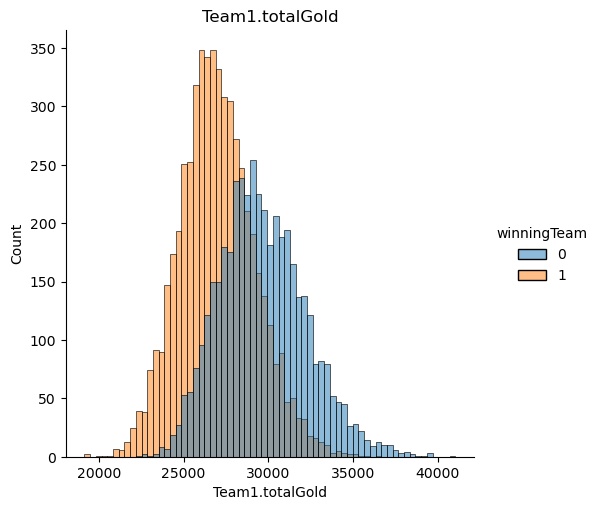

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


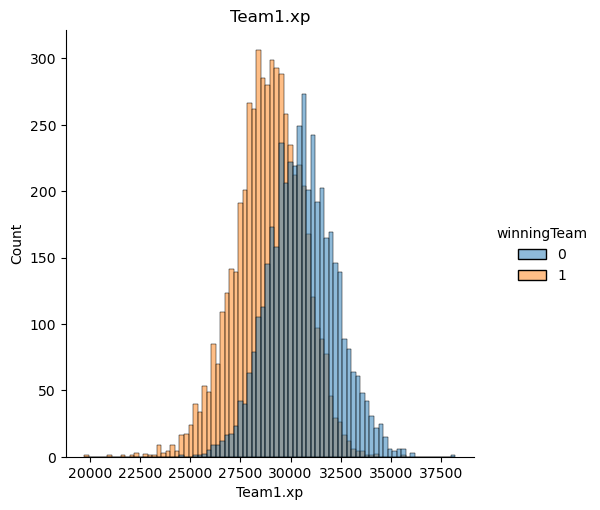

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


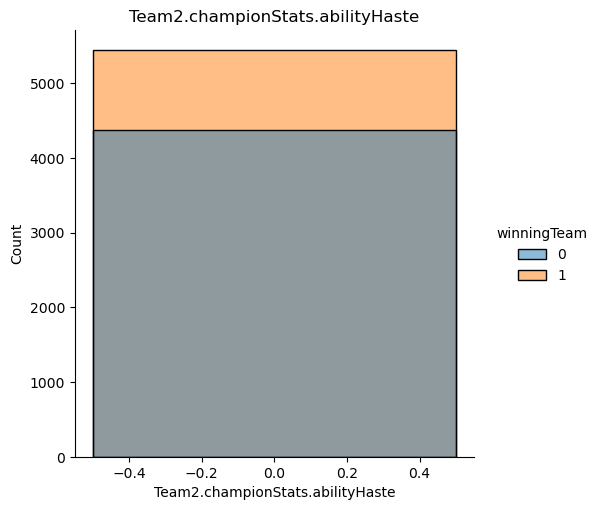

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


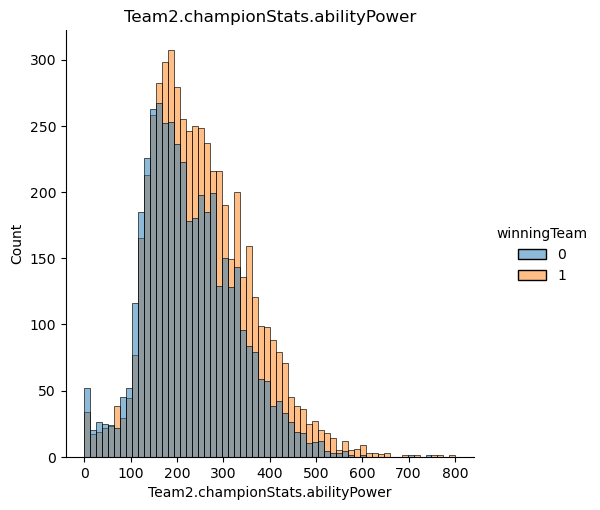

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


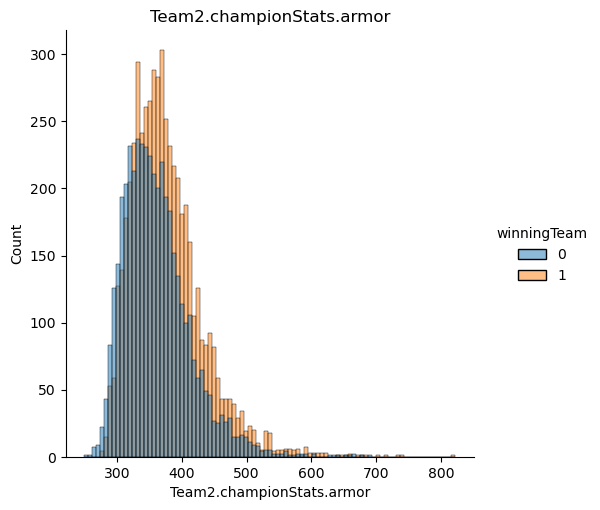

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


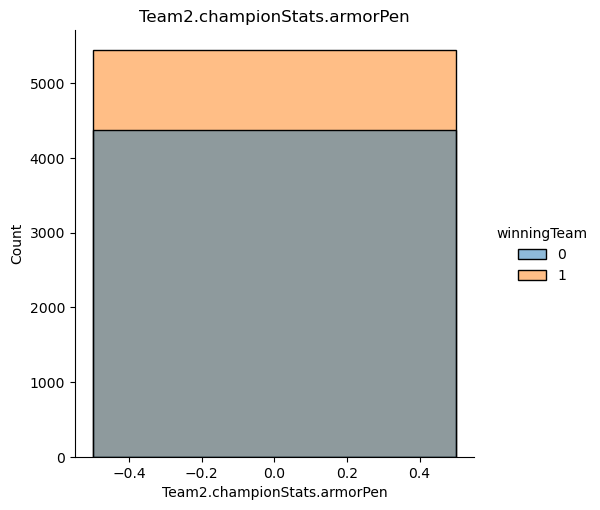

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


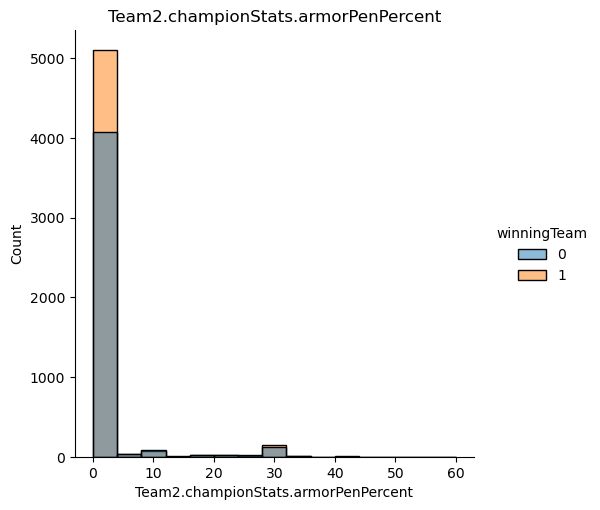

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


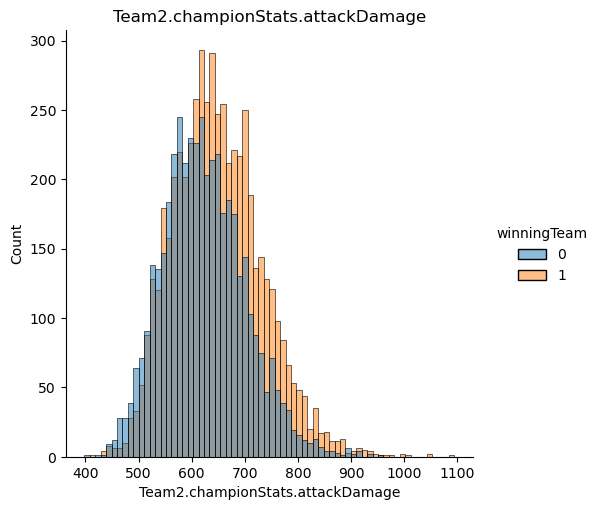

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


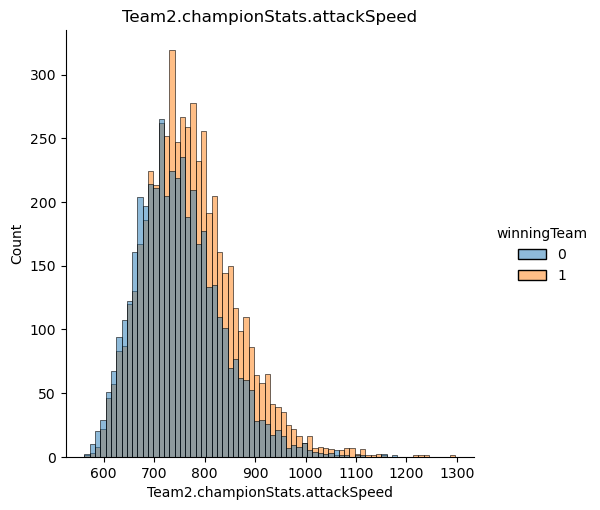

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


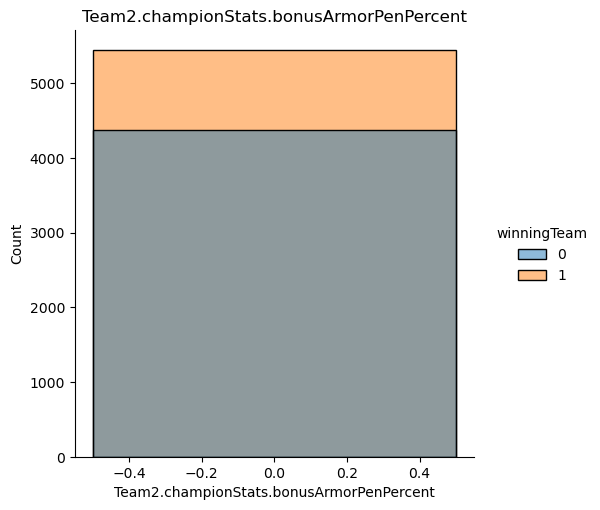

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


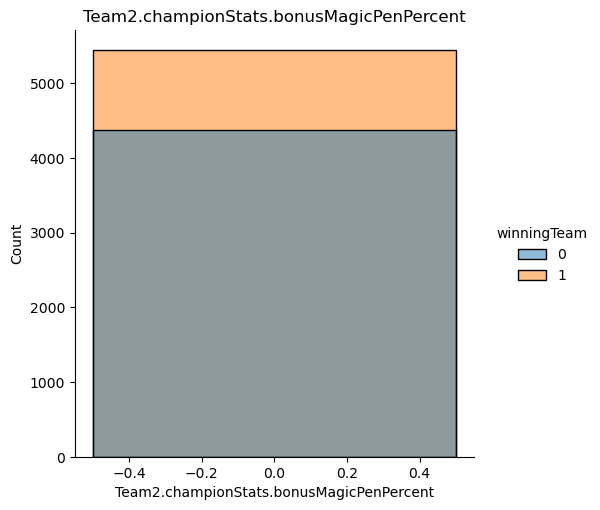

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


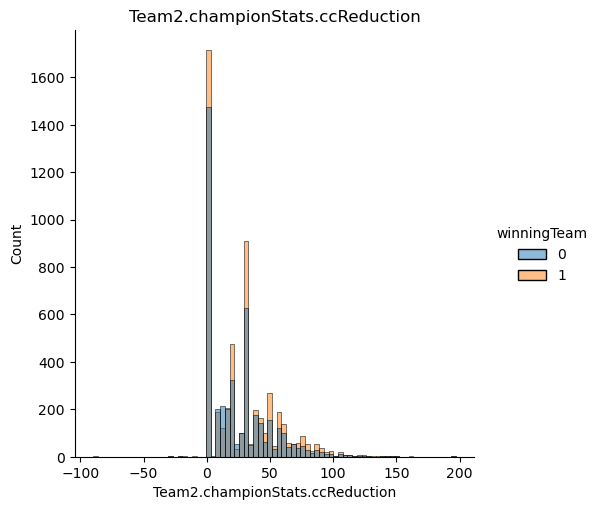

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


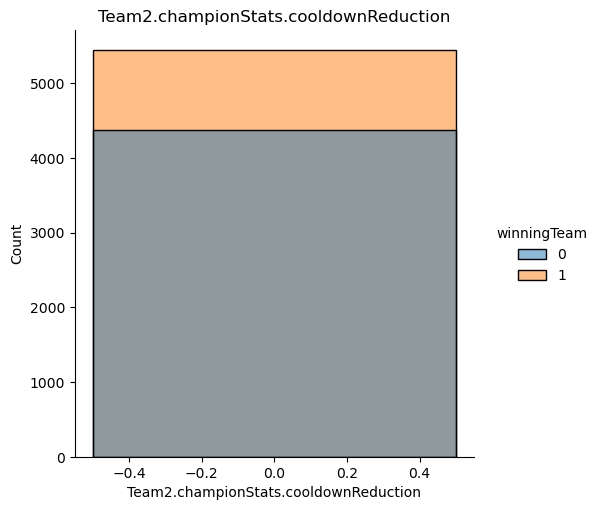

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


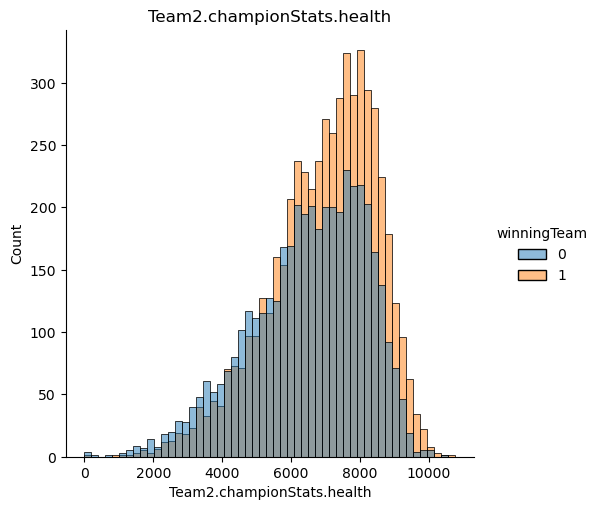

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


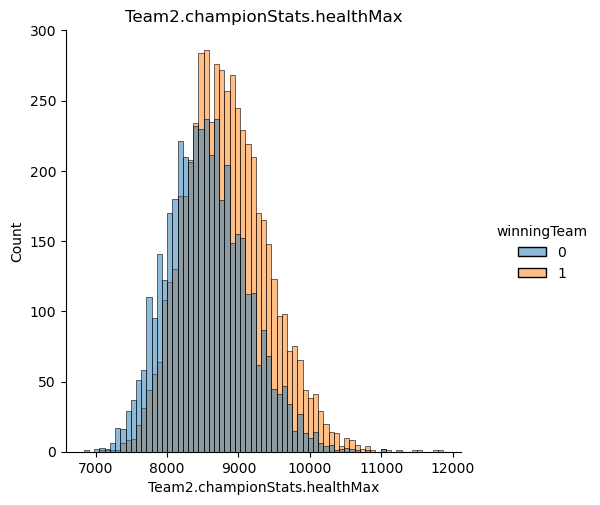

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


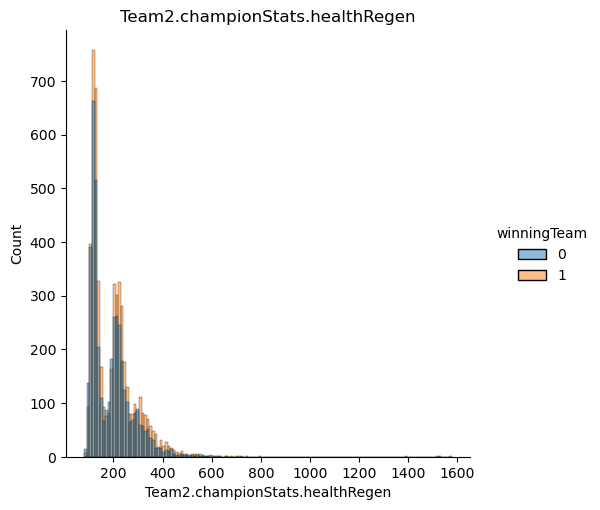

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


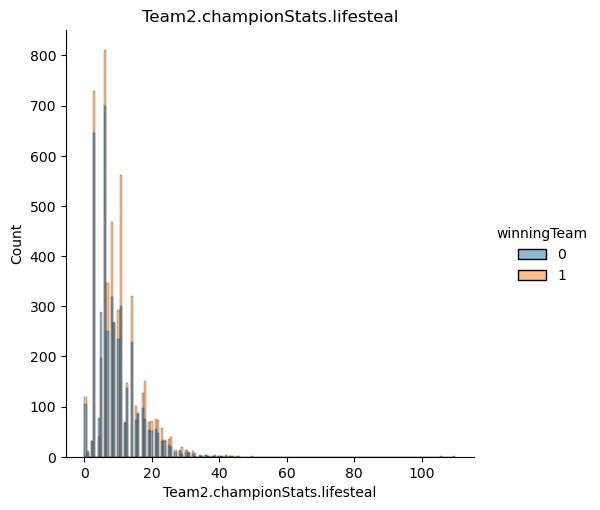

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


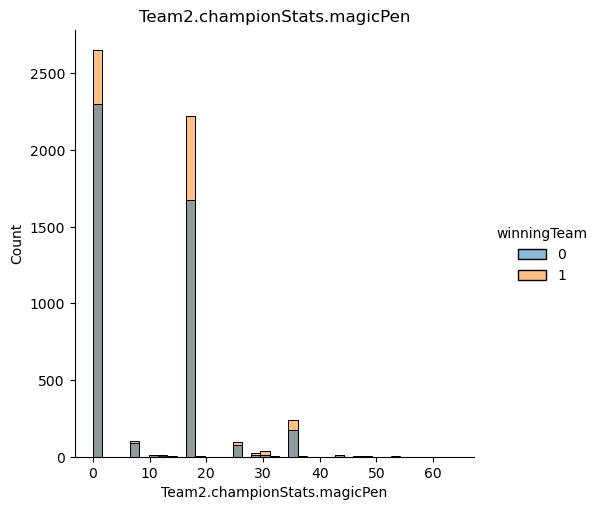

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


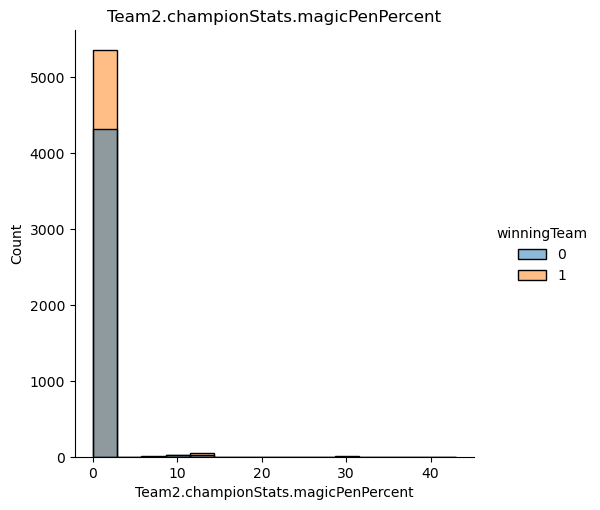

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


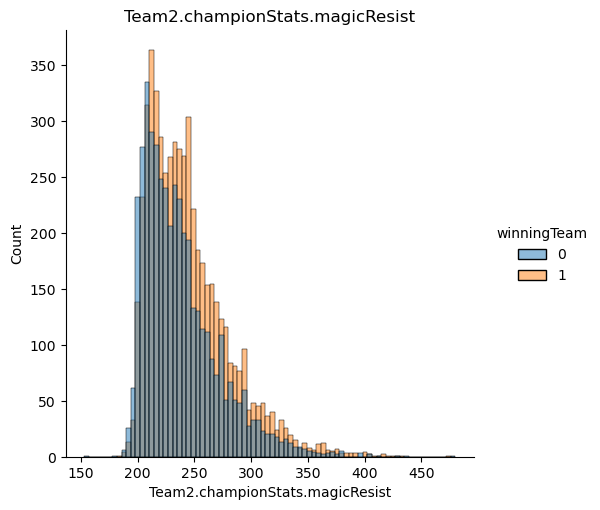

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


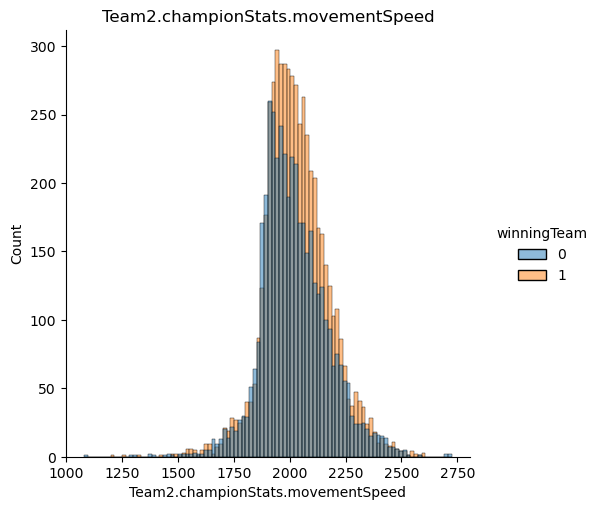

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


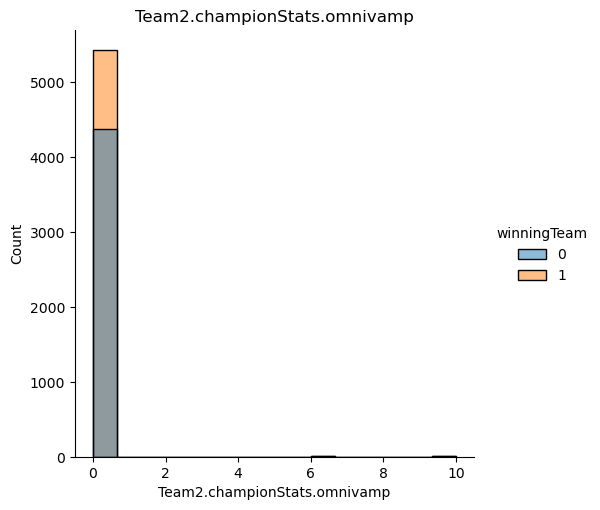

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


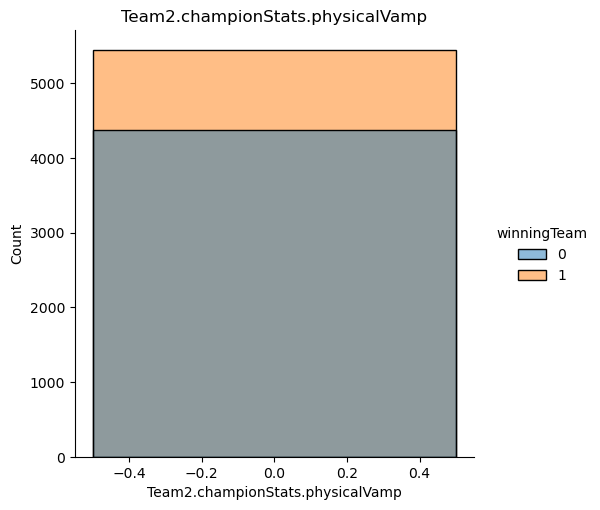

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


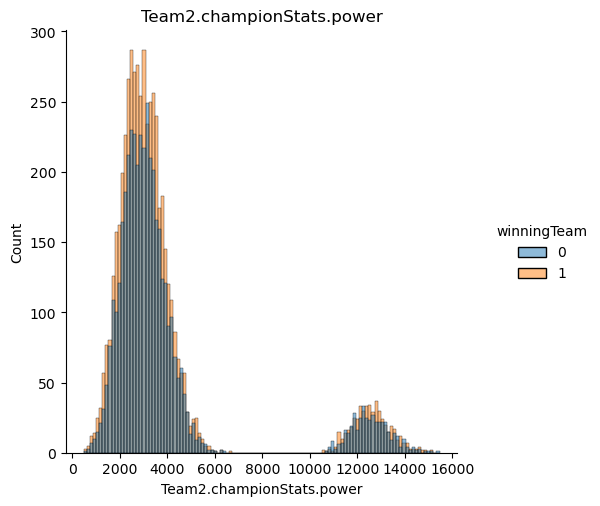

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


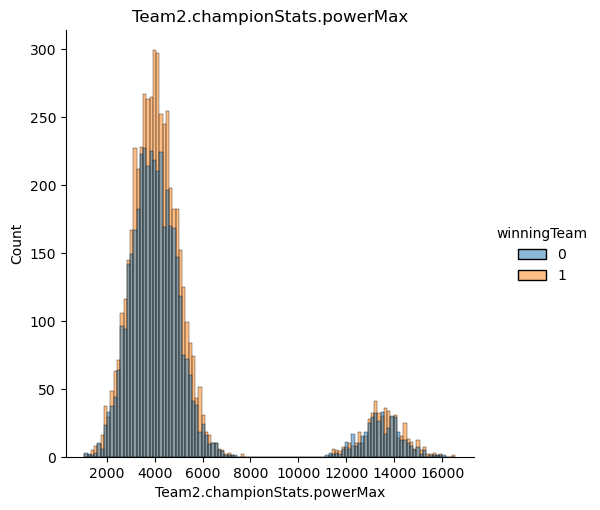

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


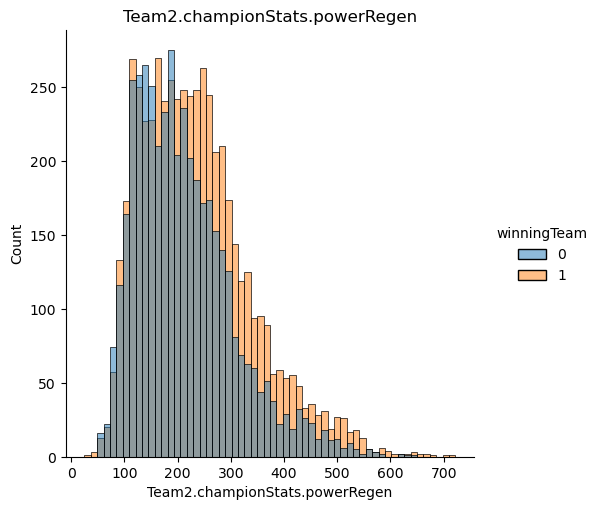

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


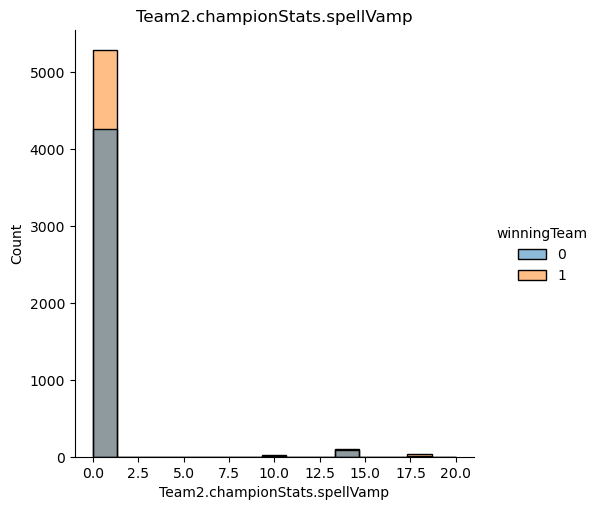

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


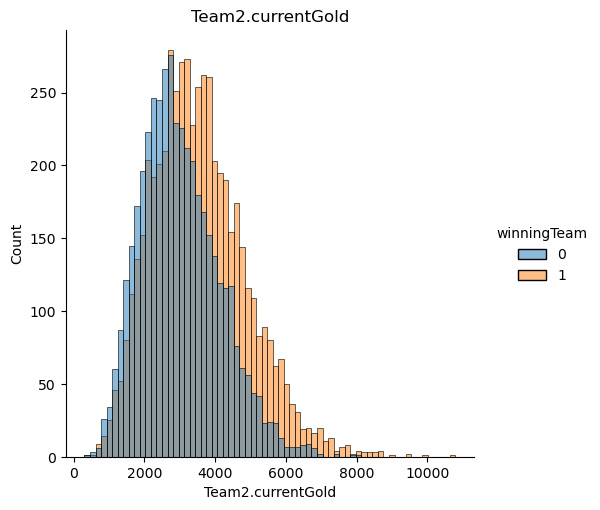

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


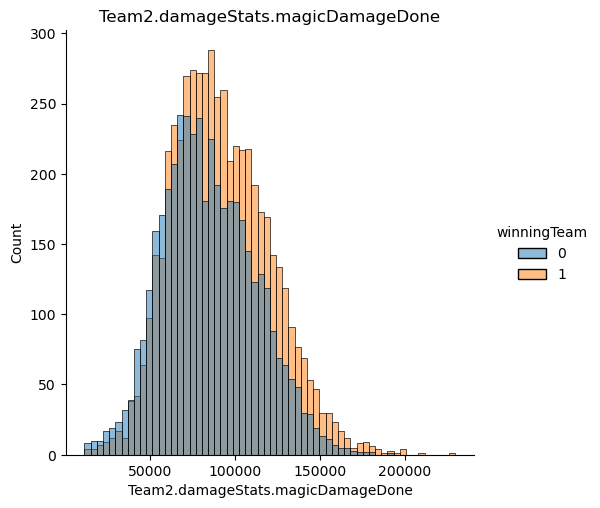

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


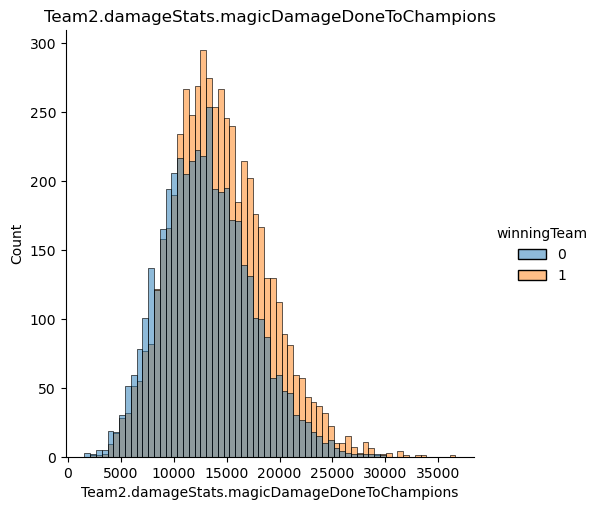

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


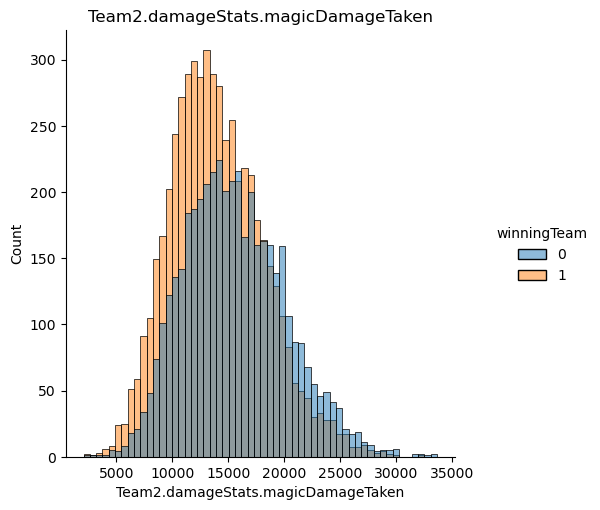

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


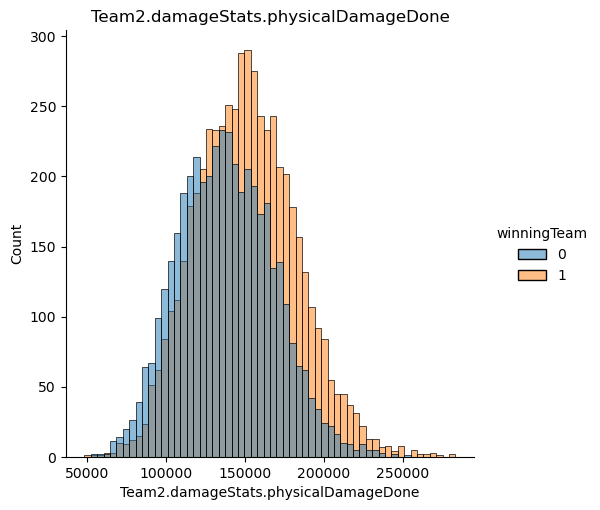

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


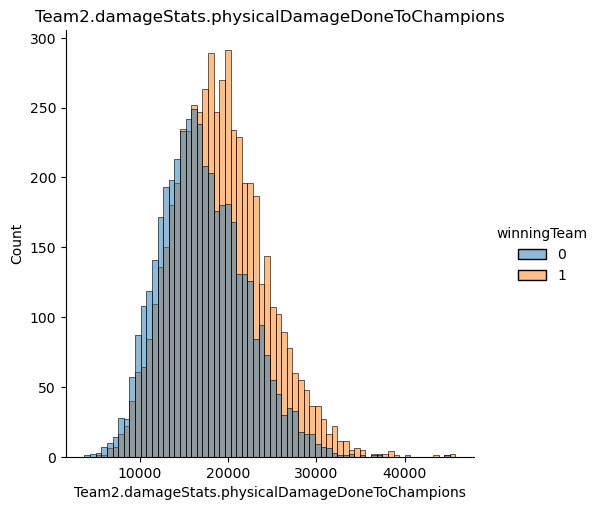

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


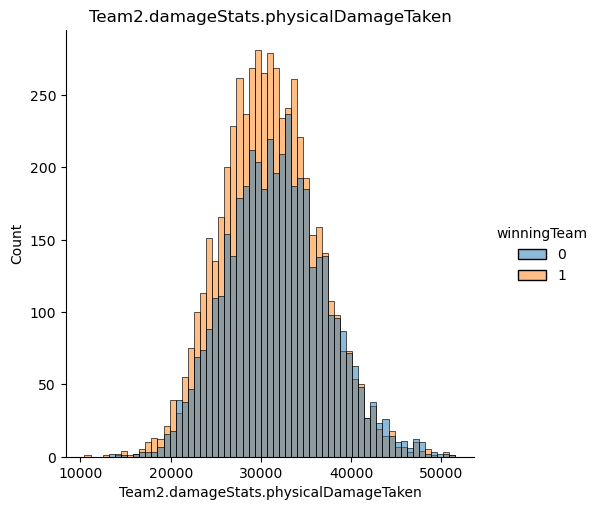

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


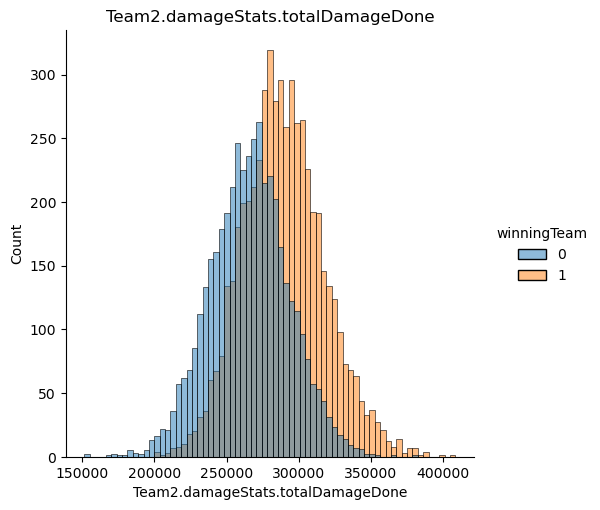

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


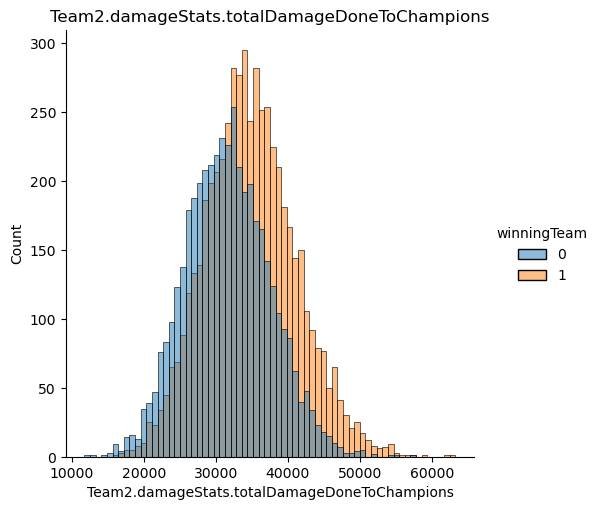

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


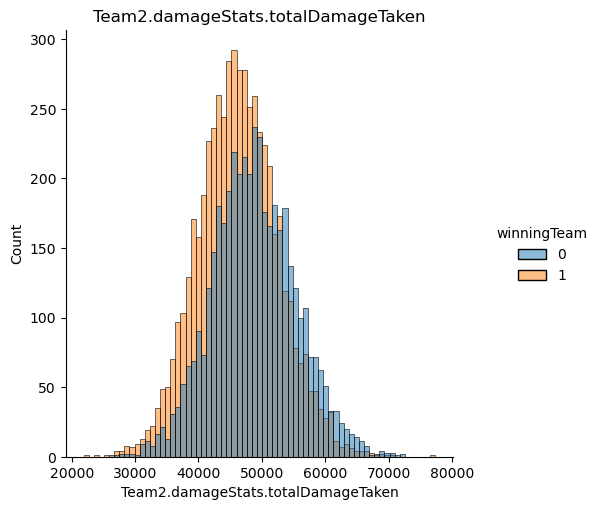

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


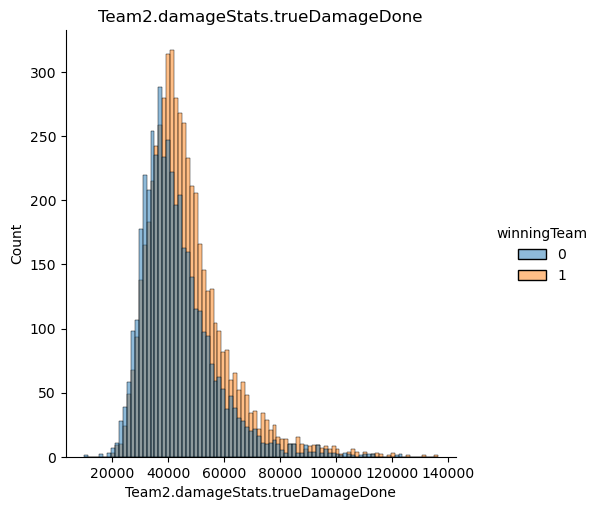

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


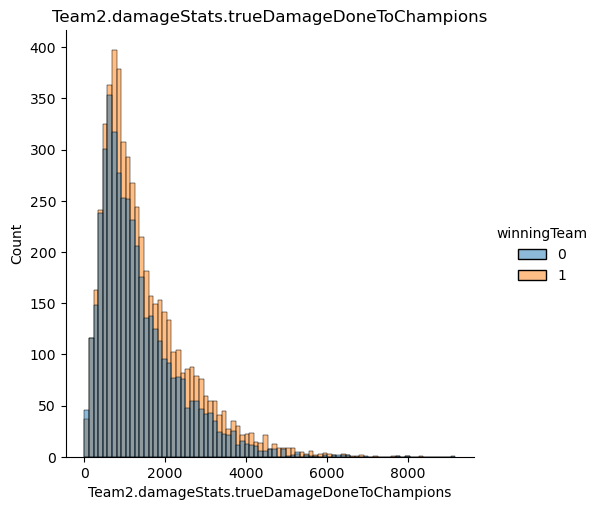

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


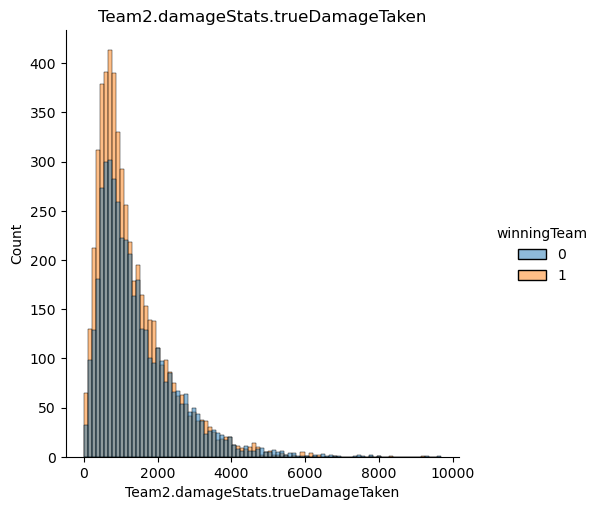

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


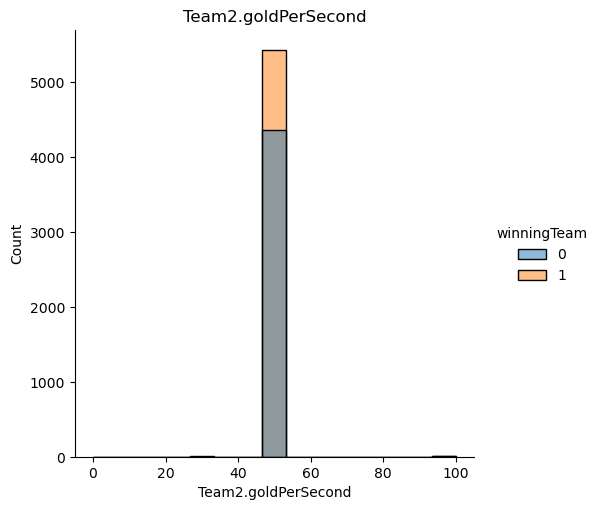

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


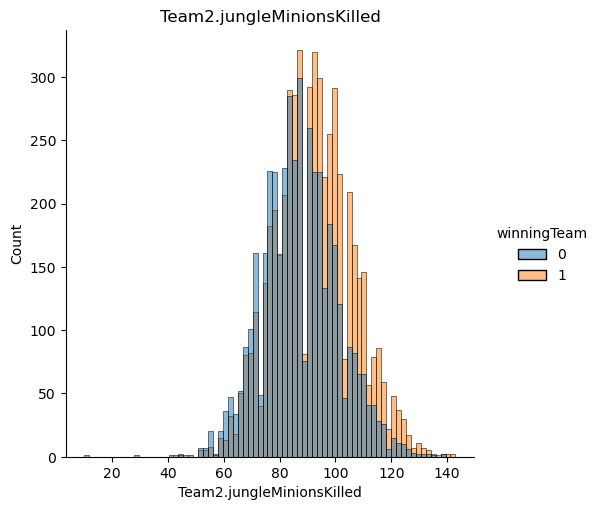

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


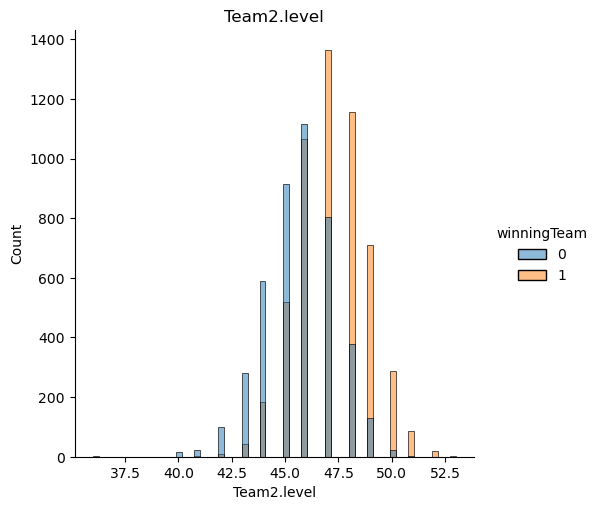

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


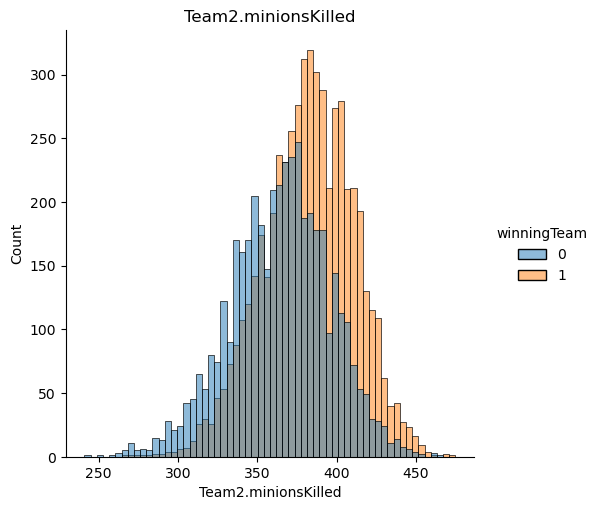

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


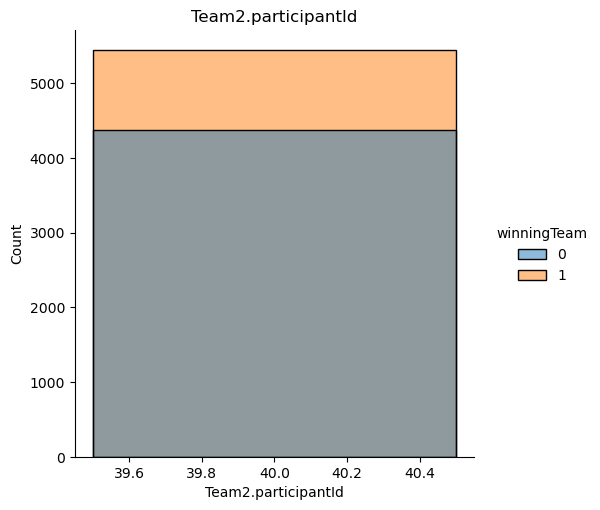

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


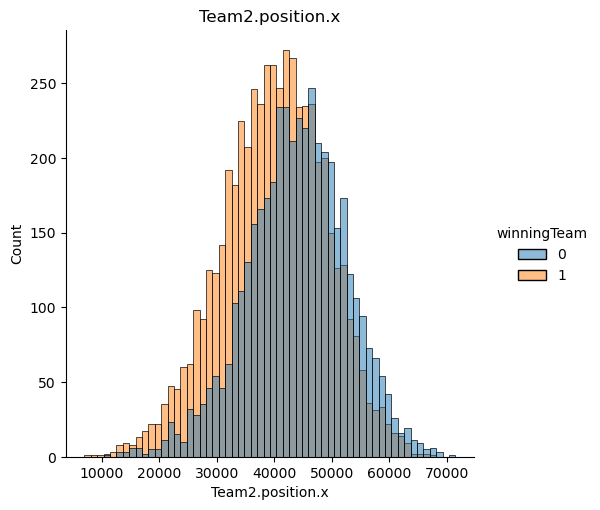

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


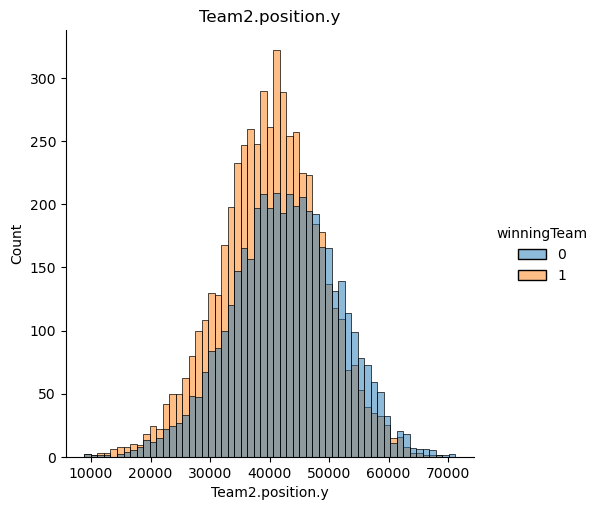

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


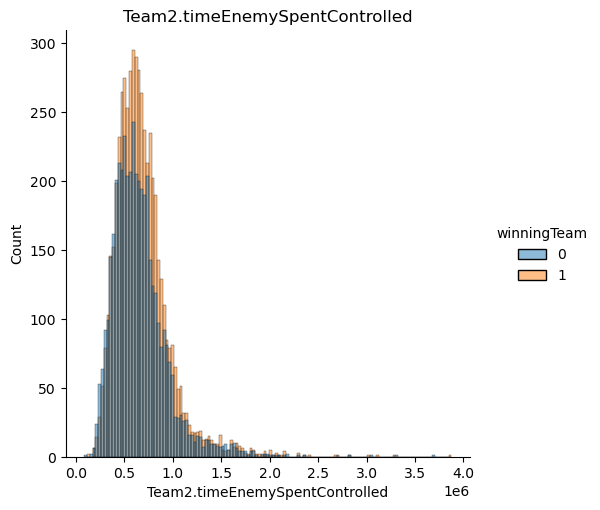

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


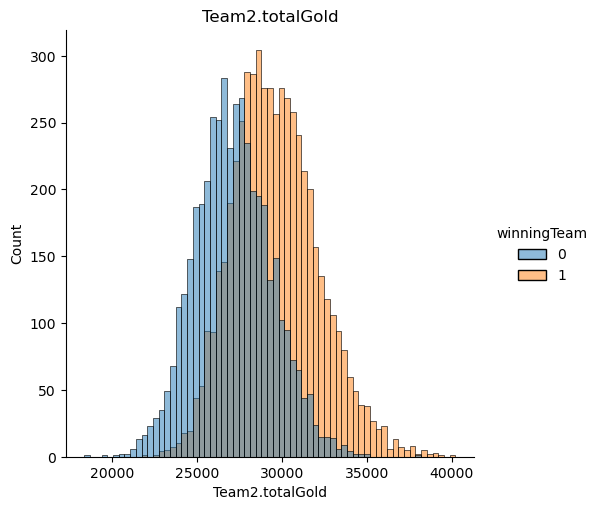

/home/emilio/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


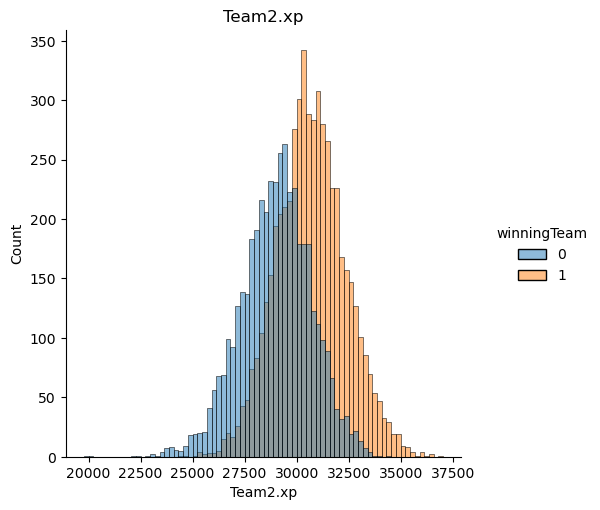

In [8]:
#We take the first half of the dataset to display variables distribution with seaborn
#display the distribution of the variables
def display_distributions(data):
    data = shuffle(data)
    for column in data.columns:
        if column != 'winningTeam':
            sns.displot(data, x=column, hue='winningTeam')
            plt.title(column)
            plt.show()

display_distributions(data)

In [9]:
to_remove = ['Team1.championStats.armorPen','Team1.championStats.abilityHaste', 'Team1.championStats.armorPenPercent', 'Team1.championStats.bonusArmorPenPercent', 'Team1.championStats.bonusMagicPenPercent', 'Team1.championStats.cooldownReduction', 'Team1.championStats.physicalVamp', 'Team1.participantId', 'Team2.championStats.armorPen', 'Team2.championStats.abilityHaste', 'Team2.championStats.armorPenPercent', 'Team2.championStats.bonusArmorPenPercent', 'Team2.championStats.bonusMagicPenPercent', 'Team2.championStats.cooldownReduction', 'Team2.championStats.physicalVamp', 'Team2.participantId']
shape1 = data.shape
print("Shape before deleting useless columns : ", data.shape)

data = data.drop(columns=to_remove, errors='ignore')
shape2 = data.shape

if shape1 == shape2:
    print("No columns were deleted")
else :
    print("Shape after deleting useless columns : ", data.shape)


Shape before deleting useless columns :  (9818, 97)
Shape after deleting useless columns :  (9818, 81)


In [10]:
data.describe()

winningTeam  Team1.championStats.abilityPower  \
count  9818.000000                       9818.000000   
mean      0.553982                        235.988389   
std       0.497103                        102.364094   
min       0.000000                          0.000000   
25%       0.000000                        161.000000   
50%       1.000000                        222.000000   
75%       1.000000                        299.000000   
max       1.000000                        776.000000   

       Team1.championStats.armor  Team1.championStats.attackDamage  \
count                9818.000000                       9818.000000   
mean                  367.605419                        633.077205   
std                    51.235050                         80.809331   
min                   263.000000                        410.000000   
25%                   331.000000                        575.000000   
50%                   360.000000                        628.000000   
75%                   395.000000                        683.000000   
max                   726.000000                       1092.000000   

       Team1.championStats.attackSpeed  Team1.championStats.ccReduction  \
count                      9818.000000                      9818.000000   
mean                        750.664799                        23.865349   
std                          85.775827                        24.537527   
min                         512.000000                       -30.000000   
25%                         690.000000                         0.000000   
50%                         740.000000                        19.000000   
75%                         799.000000                        37.000000   
max                        1283.000000                       157.000000   

       Team1.championStats.health  Team1.championStats.healthMax  \
count                 9818.000000                    9818.000000   
mean                  6677.439906                    8685.072214   
std                   1626.682522                     594.400115   
min                      0.000000                    6511.000000   
25%                   5674.000000                    8270.000000   
50%                   6882.000000                    8646.000000   
75%                   7922.000000                    9063.750000   
max                  10846.000000                   11605.000000   

       Team1.championStats.healthRegen  Team1.championStats.lifesteal  ...  \
count                       9818.00000                    9818.000000  ...   
mean                         191.54288                       9.105826  ...   
std                           87.66935                       6.186328  ...   
min                           82.00000                       0.000000  ...   
25%                          122.00000                       5.000000  ...   
50%                          169.00000                       8.000000  ...   
75%                          234.00000                      11.000000  ...   
max                         1510.00000                     108.000000  ...   

       Team2.damageStats.trueDamageTaken  Team2.goldPerSecond  \
count                        9818.000000          9818.000000   
mean                         1369.947138            50.113058   
std                          1036.203035             2.596306   
min                             0.000000             0.000000   
25%                           646.000000            50.000000   
50%                          1070.000000            50.000000   
75%                          1823.000000            50.000000   
max                          9687.000000           100.000000   

       Team2.jungleMinionsKilled  Team2.level  Team2.minionsKilled  \
count                9818.000000  9818.000000          9818.000000   
mean                   90.010084    46.502852           374.196781   
std                    13.956451     1.798736            31.125968   
min          

In [11]:
def plot_custom_graph(title, data_sample, col , xlabel, ylabel):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.scatter(data_sample["Team1."+col], data_sample["Team2."+col], c=data_sample["winningTeam"], cmap='coolwarm')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['Blue team wins', 'Red team wins']) 
    plt.show()


# Graphs

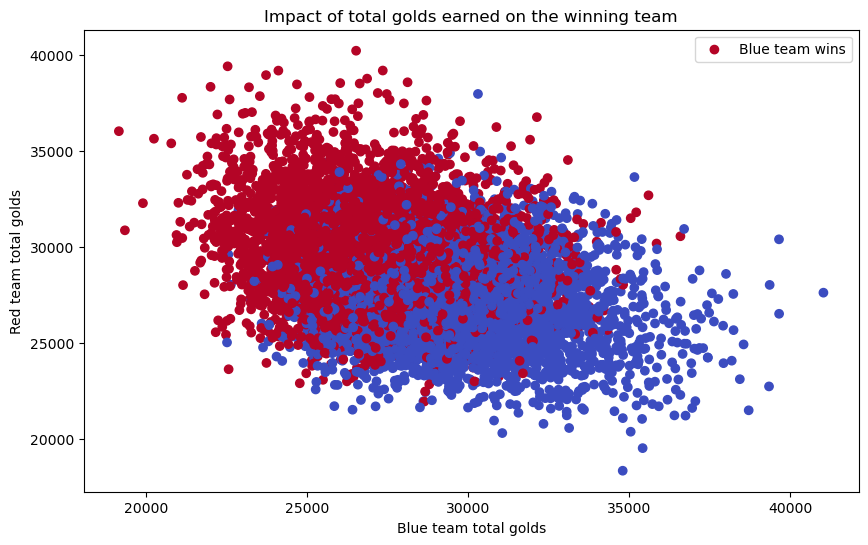

In [14]:
#Impact of total golds earned on the winning team
plot_custom_graph('Impact of total golds earned on the winning team', data, 'totalGold', 'Blue team total golds', 'Red team total golds')

League of legends is game heavily influenced by golds as this graph shows.

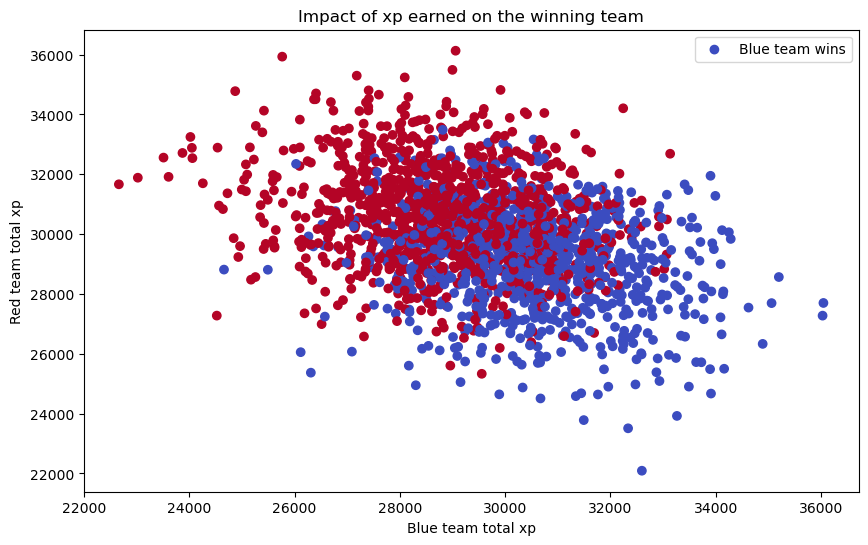

In [ ]:
#Impact of total xp earned on the winning team
plot_custom_graph('Impact of xp earned on the winning team', data, 'xp', 'Blue team total xp', 'Red team total xp')

It seems that the experience points earned is important 

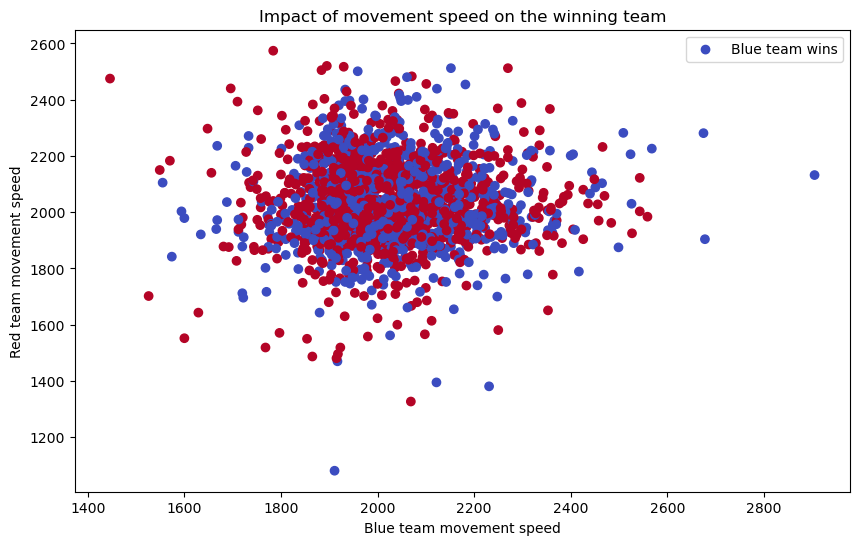

In [ ]:
plot_custom_graph('Impact of movement speed on the winning team', data, 'championStats.movementSpeed', 'Blue team movement speed', 'Red team movement speed')

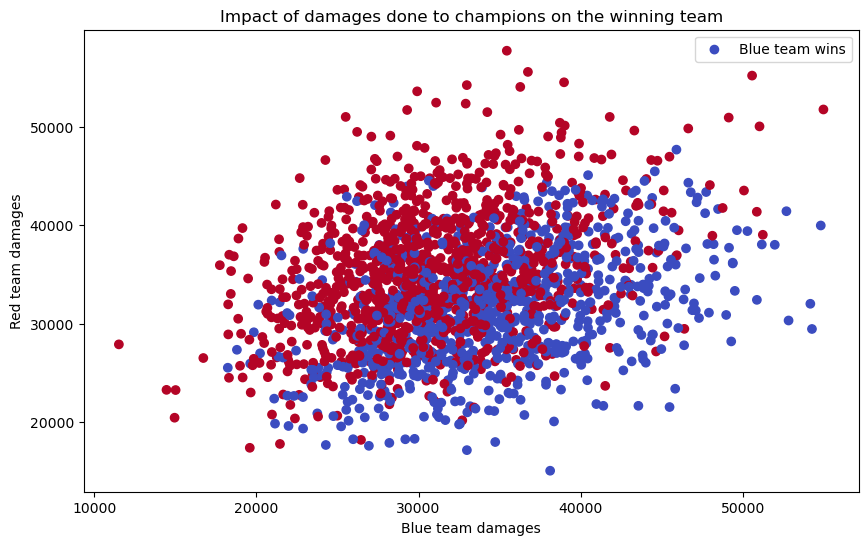

In [ ]:
plot_custom_graph('Impact of damages done to champions on the winning team', data, 'damageStats.totalDamageDoneToChampions', 'Blue team damages', 'Red team damages')

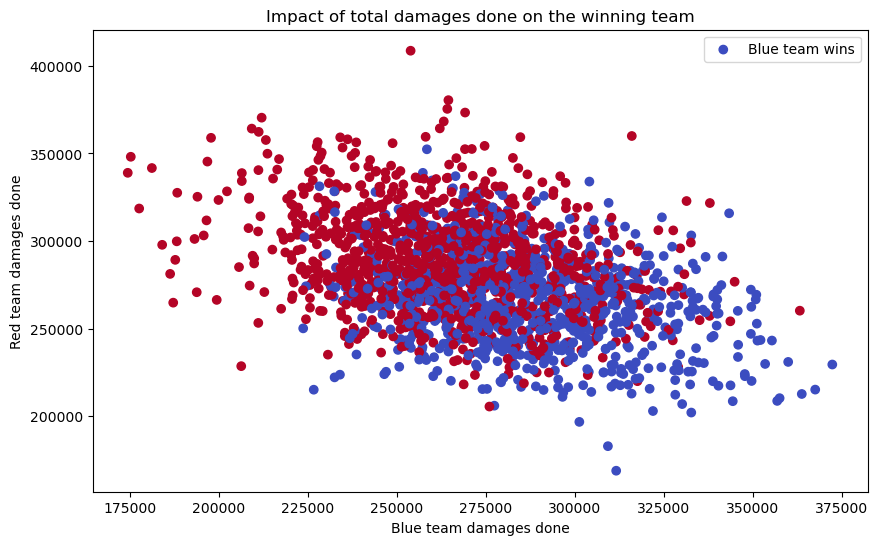

In [ ]:
plot_custom_graph('Impact of total damages done on the winning team', data, 'damageStats.totalDamageDone', 'Blue team damages done', 'Red team damages done')

# Jalon 2

Nous voulons faire une régression logistique pénalisée.

Ce choix se justifie car nous cherchons à prédire une variable qualitative binaire.

Pour les hyperparamètres, nous allons utiliser une gridSearchCV pour selectionner les meilleurs hyperparamètres.

Ceux-ci sont:

    -la pénalité

    -l'inverse de la force de régularisation, C

    -le nombre d'itérations maximal

    -le ratio entre l1 et l2 pour l'elasticNet

Nous n'utilisons pas un randomSearch pour les hyperparamètres car il n'y a pas tant de valeurs à tester.

Pour ajuster nos hyperparamètres, nous utilisons plusieurs cross-validations:

    -Une, en interne, pour la sélection des hyperparamètres

    -Une, en externe, pour l'évaluation de la généralisation de notre modèle

On compare donc par cross-validation la geénéralisation de plusieurs hyperparamètres, eux-meme sélectionnés par cross-validation.

Pour cela, on a séparé nos données plusieurs fois en train, validation et test set.

In [ ]:
data

Team1.championStats.abilityHaste  Team1.championStats.abilityPower  \
0                                    0                               177   
1                                    0                               185   
2                                    0                               186   
3                                    0                               195   
4                                    0                               230   
...                                ...                               ...   
5003                                 0                               320   
5004                                 0                               210   
5005                                 0                               244   
5006                                 0                               173   
5007                                 0                               321   

      Team1.championStats.armor  Team1.championStats.armorPen  \
0                           352                             0   
1                           446                             0   
2                           466                             0   
3                           307                             0   
4                           348                             0   
...                         ...                           ...   
5003                        295                             0   
5004                        328                             0   
5005                        290                             0   
5006                        311                             0   
5007                        374                             0   

      Team1.championStats.armorPenPercent  Team1.championStats.attackDamage  \
0                                       0                               628   
1                                       0                               551   
2                                       0                               603   
3                                       0                               746   
4                                      30                               759   
...                                   ...                               ...   
5003                                    0                               631   
5004                                    0                               679   
5005                                    0                               609   
5006                                    0                               586   
5007                                    0                               670   

      Team1.championStats.attackSpeed  \
0                                 817   
1                                 618   
2                                 826   
3                                 945   
4                                 635   
...                               ...   
5003                              709   
5004                              794   
5005                              689   
5006                              710   
5007                              733   

      Team1.championStats.bonusArmorPenPercent  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   
...                                        ...   
5003                                         0   
5004                                         0   
5005                                         0   
5006                                         0   
5007                                         0   

      Team1.championStats.bonusMagicPenPercent  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                  

In [ ]:
#Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42) #70% training, 30% testing

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

pip = make_pipeline(StandardScaler(), LogisticRegression()) #Create a pipeline with a standard scaler and a logistic regression

# Définition des paramètres à rechercher
parameters = {'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none'], #l1 pour Lasso, l2 pour Ridge
              'logisticregression__l1_ratio': [0.1, 0.5, 0.9],  #Ratio de mélange de la régularisation (0 = l2, 1 = l1)
              'logisticregression__C': [0.1, 1, 10, 100, 1000], #Inverse de la force de régularisation
              'logisticregression__max_iter' : [10, 100, 1000, 2500, 5000]}  #Nombre d'itérations maximales

grid_search = GridSearchCV(pip, param_grid=parameters, scoring='accuracy', cv=5, n_jobs=-1)



In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate( #Cross validation
    grid_search, data, target, cv=5, n_jobs=-1, return_estimator=True
)

/home/emilio/anaconda3/lib/python3.11/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y contains NaN.

In [ ]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]): #Display the best hyperparameters for each fold
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.1, 'logisticregression__max_iter': 10, 'logisticregression__penalty': 'l2'}
Best hyperparameters for fold #2:
{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.1, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'none'}
Best hyperparameters for fold #3:
{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.1, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'none'}
Best hyperparameters for fold #4:
{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.1, 'logisticregression__max_iter': 10, 'logisticregression__penalty': 'l2'}
Best hyperparameters for fold #5:
{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.1, 'logisticregression__max_iter': 10, 'logisticregression__penalty': 'l2'}


On voit que le meilleur choix de pénalité est la pénalité Lasso (l2).

Aussi, on sélectionne des valeurs basses pour C et le nombre max d'itérations.

On peut ignorer l1_ratio car la pénalité elasticNet n'est pas la meilleure.

# Performances sur le jeu de données test

In [ ]:
cv_results = pd.DataFrame(cv_results)
print(cv_results[["fit_time", "score_time", "test_score"]])


     fit_time  score_time  test_score
0  182.510187    0.005391    0.760183
1  184.283013    0.002980    0.759674
2  184.268438    0.003667    0.752037
3  179.681556    0.004465    0.769231
4  184.989994    0.001930    0.771268


In [ ]:

cv_test_scores = cv_results["test_score"]
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} ± {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.762 ± 0.008


On voit avec notre modèle généralise bien car la variance est faible.


# Conclusion jalon 2

On conclut donc de cela qu'avec une régression logistique un peu tunée on arrive à prédire l'issue de ~ 77,2% des parties en ayant les informations à 15 minutes de jeu. 

# Jalon 3


In [147]:
import requests
import json
import time
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


On veut donc ici déterminer les meilleurs paramètres de max_features et de n_estimators pour notre foret aléatoire

On va pour cela créer une matrice de la taille de nos deux paramètres ce qui permettra de bien visualiser par la suite et de garder les erreurs oob correspondantes

In [148]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

In [166]:
#RandomForest par défaut
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
default_score = rf.score(X_test, y_test)
print(f"Default RandomForest score: {default_score:.3f}")

Default RandomForest score: 0.760


In [167]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [153]:
n_estimators = [10, 100, 500, 1000, 2500, 5000]
max_features = np.arange(0.1, 1.1, 0.1) #en pourcentage pour vraiment tout tester

In [154]:
max_features


array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [155]:
oob_accuracys = np.zeros((len(n_estimators), len(max_features)))

In [156]:
oob_accuracys


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [157]:
n_estimators_accuracy = []
for elt in n_estimators:
    rf = RandomForestClassifier(n_estimators=elt, oob_score=True, n_jobs=-1)
    rf.fit(X_train, y_train)
    n_estimators_accuracy.append(rf.oob_score_)

/home/emilio/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


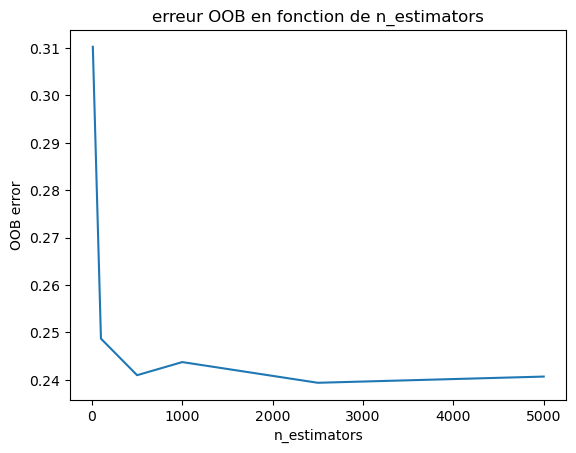

In [158]:
#graphique 
errors = [1 - x for x in n_estimators_accuracy]
plt.plot(n_estimators, errors)
plt.xlabel('n_estimators')
plt.ylabel('OOB error')
plt.title('erreur OOB en fonction de n_estimators')
plt.show()

On observe bien que la zone qui nous intéresse est aux alentours de 500 et qu'il y a ensuite un plateau. On reserre donc entre 0 et 1000 par pas de 50 pour zoomer sur cette partie intéressante

In [159]:
n_estimators = np.arange(100, 1000, 100)
n_estimators_accuracy = []
for elt in n_estimators:
    rf = RandomForestClassifier(n_estimators=elt, oob_score=True, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    n_estimators_accuracy.append(rf.oob_score_)

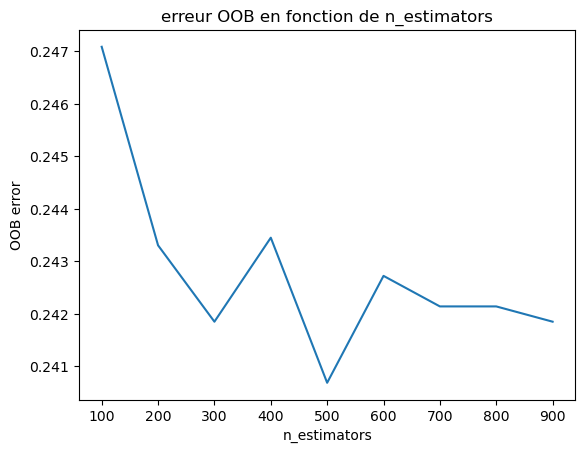

In [160]:
#graphique 
errors = [1 - x for x in n_estimators_accuracy]
plt.plot(n_estimators, errors)
plt.xlabel('n_estimators')
plt.ylabel('OOB error')
plt.title('erreur OOB en fonction de n_estimators')
plt.show()

En regardant l'échelle des ordonnées on se rend compte que la différence est assez négligeable, on parle de millième de différence sur l'accuracy. On considèrera quand même qu'une valeur autour de 500 ou 600 sera idéale.

On a bien une matrice de zeros avec toutes les possibilitées de combinaisons entre les paramètres, on resserera les n_estimators si besoin

In [161]:
max_features_accuracy = []
for elt in max_features:
    rf = RandomForestClassifier(n_estimators=550, max_features=elt, oob_score=True, n_jobs=-1, random_state=42)
    rf.fit(X_train, y_train)
    max_features_accuracy.append(rf.oob_score_)

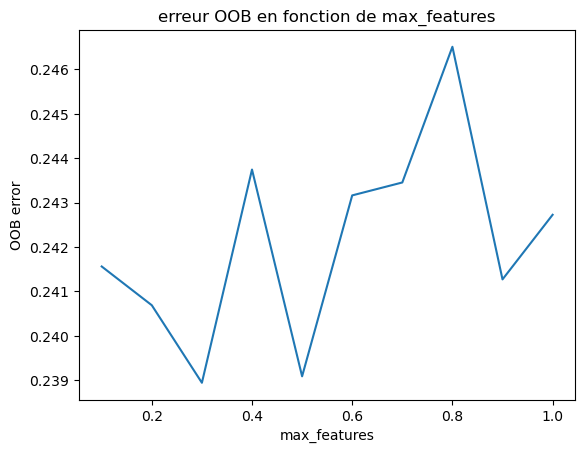

In [162]:
#graphique
errors = [1 - x for x in max_features_accuracy]
plt.plot(max_features, errors)
plt.xlabel('max_features')
plt.ylabel('OOB error')
plt.title('erreur OOB en fonction de max_features')
plt.show()

On aurait donc un maximum d'accuracy avec n_estimators=550 et max_features=40%



In [163]:
rf = RandomForestClassifier(n_estimators=550, max_features=0.4, oob_score=True, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
print("OOB accuracy : ", rf.oob_score_)
test_accuracy = rf.score(X_test, y_test)
print("Test accuracy : ", test_accuracy)
print("Une différence de ", default_score - test_accuracy)

OOB accuracy :  0.7562572759022119
Test accuracy :  0.7606924643584522
Une différence de  -0.0010183299389002753


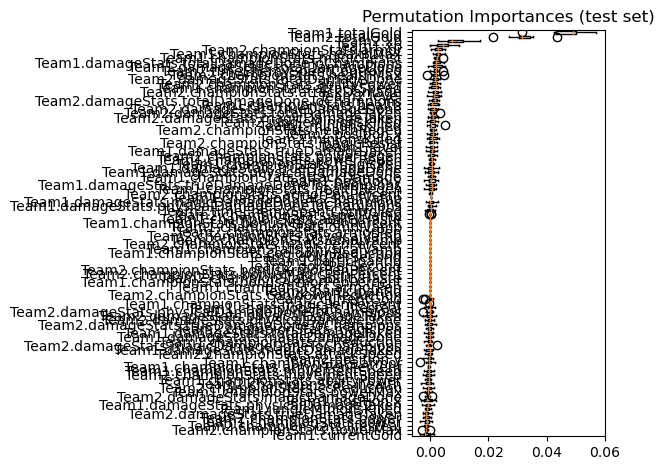

In [ ]:
#MDA (Mean Decrease Accuracy) : Importance des variables
#On va regarder les 26 variables les plus importantes 
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

On observe rien car c'est pas lisible, on va retirer environ 30% des variables les plus inutiles selon la MDA.

In [84]:
#Remove the less important features
sorted_idx

array([25, 70, 62, 21, 69, 85, 39, 31, 43, 74, 22, 57, 59,  1, 66, 18,  4,
        2, 92, 54, 28, 75,  9, 26, 34, 63, 84, 77, 79, 78, 14, 16, 73, 58,
       90,  3,  7, 48, 56, 55, 86, 42, 38, 10, 20, 64, 67, 68, 51, 19,  8,
        0, 72, 45, 30, 27, 24, 52, 13, 36, 44,  5, 29, 35, 15, 23, 71, 37,
       40, 65, 89, 91, 61, 41, 87, 76, 82, 83, 11, 81, 88, 53,  6, 49, 80,
       60, 93, 32, 33, 17, 12, 50, 47, 95, 94, 46])

In [127]:
to_remove = X_test.columns[sorted_idx[:94]]
to_remove

Index(['Team1.currentGold', 'Team2.championStats.powerMax',
       'Team2.championStats.lifesteal', 'Team1.championStats.power',
       'Team2.championStats.power', 'Team2.damageStats.trueDamageTaken',
       'Team1.jungleMinionsKilled', 'Team1.damageStats.physicalDamageTaken',
       'Team1.position.x', 'Team2.damageStats.magicDamageDone',
       'Team1.championStats.powerMax', 'Team2.championStats.ccReduction',
       'Team2.championStats.health', 'Team1.championStats.abilityPower',
       'Team2.championStats.movementSpeed',
       'Team1.championStats.movementSpeed',
       'Team1.championStats.armorPenPercent', 'Team1.championStats.armor',
       'Team2.position.y', 'Team2.championStats.attackSpeed',
       'Team1.damageStats.magicDamageTaken',
       'Team2.damageStats.magicDamageDoneToChampions',
       'Team1.championStats.ccReduction', 'Team1.damageStats.magicDamageDone',
       'Team1.damageStats.totalDamageTaken', 'Team2.championStats.magicPen',
       'Team2.damageStats.tru

In [129]:
subset_data = data.drop(columns=to_remove, errors='ignore')
subset_data

Team1.totalGold  Team2.totalGold
0               27130            24603
1               24094            27729
2               26168            31166
3               28537            30368
4               28091            28765
...               ...              ...
9813            28695            25296
9814            28729            29257
9815            37768            27287
9816            29872            28472
9817            28792            27138

[9818 rows x 2 columns]

In [130]:
#test le modèle sur notre nouveau dataset
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(subset_data, target, test_size=0.3, random_state=42)

In [131]:
rf = RandomForestClassifier(n_estimators=550, max_features=0.5, oob_score=True, n_jobs=-1, random_state=42)
rf.fit(X_train_subset, y_train_subset)
subset_oob_accuracy = rf.score(X_test_subset, y_test_subset)
print("OOB score : ", rf.oob_score_)
print("Test score : ", subset_oob_accuracy)

OOB score :  0.7323923166472642
Test score :  0.7182620502376104


In [132]:
#Différence entre les deux scores
print("Différence entre les deux scores : ", test_accuracy - subset_oob_accuracy)

Différence entre les deux scores :  0.04243041412084181


In [134]:
oob_accuracys_var = []

In [135]:
for i in range(96):
    subset_data = data.drop(columns=to_remove[:i], errors='ignore')
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(subset_data, target, test_size=0.3, random_state=42)
    rf = RandomForestClassifier(n_estimators=550, max_features=0.5, oob_score=True, n_jobs=-1, random_state=42)
    rf.fit(X_train_subset, y_train_subset)
    subset_oob_accuracy = rf.score(X_test_subset, y_test_subset)
    oob_accuracys_var.append(subset_oob_accuracy)

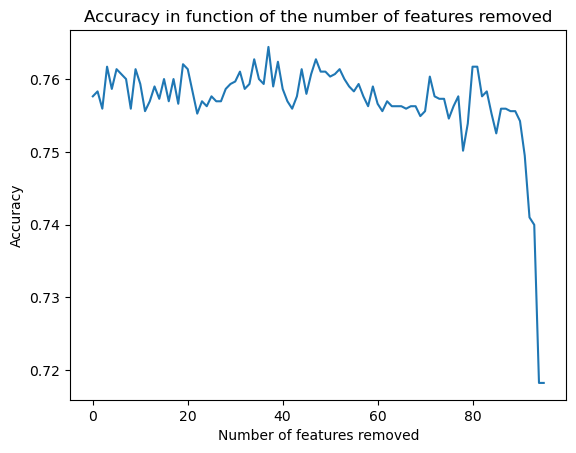

In [138]:
#Courbe of the accuracy in function of the number of features
plt.plot(range(96), oob_accuracys_var)
plt.xlabel('Number of features removed')
plt.ylabel('Accuracy')
plt.title('Accuracy in function of the number of features removed')
plt.show()

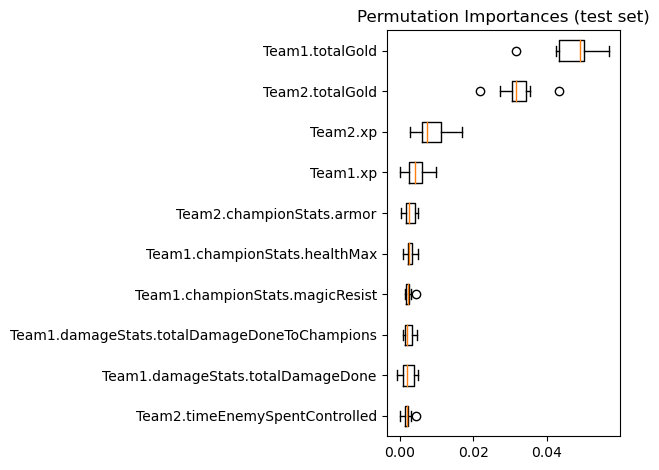

In [146]:
#On garde les 10 features les plus importantes
sorted_idx = result.importances_mean.argsort()[data.shape[1]-10:]

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# flop